In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import Parameter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import torch.optim as optim
from torch_geometric.nn.conv import feast_conv
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [148]:
# Definition of the damped sine wave functions
def damped_sine_wave(t, A, omega, phi, alpha):
    return A * np.exp(-alpha * t) * np.sin(omega * t + phi)

def damped_sine_wave_2(t, A1, omega1, phi1, alpha1, A2, omega2, phi2, alpha2):
    return A1 * np.exp(-alpha1 * t) * np.sin(omega1 * t + phi1) + A2 * np.exp(-alpha2 * t) * np.sin(omega2 * t + phi2)

In [149]:
#Time history specifics
dt = 0.01
T = 2
time = np.arange(0,T,dt)

data = []
current_group = []
# load dataset (too large to push to git)
with open('Data\\trussBridgeData2.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
displacement_z_data = np.array(data)
print(displacement_z_data.shape)

(2121, 32, 200)


In [116]:
displacement_z_data_reduced = displacement_z_data[:200][:][:]
length = displacement_z_data_reduced.shape[0]
width = displacement_z_data_reduced.shape[1]
depth = displacement_z_data_reduced.shape[2]

print(length, width, depth)

200 32 200


In [117]:
# save git pushable sized dataset

np.savetxt("Data\\trussBridgeData2_reduced.txt",displacement_z_data_reduced.flatten())

In [120]:
# run this code cell to load reduced displacement data

loaded_data = np.loadtxt("Data\\trussBridgeData2_reduced.txt")
reshaped_displacement_data = loaded_data.reshape((length, width, depth))
print(reshaped_displacement_data.shape)
displacement_z_data = reshaped_displacement_data

(200, 32, 200)


In [121]:
#Time history specifics, rising truss
dt = 0.01
T = 2
time = np.arange(0,T,dt)

data = []
current_group = []
with open('Data\\rising_truss_Data.txt') as f:
    for line in f:
        if line.strip():  # If the line is not empty
            row = [float(x) for x in line.split()]
            current_group.append(row)
        else:  # If the line is empty
            if current_group:
                data.append(current_group)
                current_group = []
displacement_z_data_rising = np.array(data)
print(displacement_z_data_rising.shape)

(1, 32, 200)


In [150]:
#Load truss data
data_set = torch.load("Data\\trussDataObjects2")
print(data_set[120].x)

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 5.0000e+03, 0.0000e+00],
        [2.0000e+00, 2.9400e+03, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 2.9400e+03, 5.0000e+03, 0.0000e+00],
        [4.0000e+00, 5.8800e+03, 0.0000e+00, 0.0000e+00],
        [5.0000e+00, 5.8800e+03, 5.0000e+03, 0.0000e+00],
        [6.0000e+00, 8.8200e+03, 0.0000e+00, 0.0000e+00],
        [7.0000e+00, 8.8200e+03, 5.0000e+03, 0.0000e+00],
        [8.0000e+00, 1.1760e+04, 0.0000e+00, 0.0000e+00],
        [9.0000e+00, 1.1760e+04, 5.0000e+03, 0.0000e+00],
        [1.0000e+01, 1.4700e+04, 0.0000e+00, 0.0000e+00],
        [1.1000e+01, 1.4700e+04, 5.0000e+03, 0.0000e+00],
        [1.2000e+01, 1.7640e+04, 0.0000e+00, 0.0000e+00],
        [1.3000e+01, 1.7640e+04, 5.0000e+03, 0.0000e+00],
        [1.4000e+01, 2.0580e+04, 0.0000e+00, 0.0000e+00],
        [1.5000e+01, 2.0580e+04, 5.0000e+03, 0.0000e+00],
        [1.6000e+01, 2.3520e+04, 0.0000e+00, 0.0000e+00],
        [1.700

In [151]:
data_set_rising = torch.load("Data\\rising_truss_DataObjects")

2121


In [144]:
# run this cell if using reduced dataset

data_set_new = []
for i in range(0, len(data_set)):
    if (data_set[i].bridge_id < 200):
        data_set_new.append(data_set[i])
data_set = data_set_new
print(len(data_set))

200


2.7955942153930664 72.52654266357422 -1.9662736654281616 2.579780101776123 1.1081480979919434 122.35687255859375 -2.086386203765869 17.17884063720703


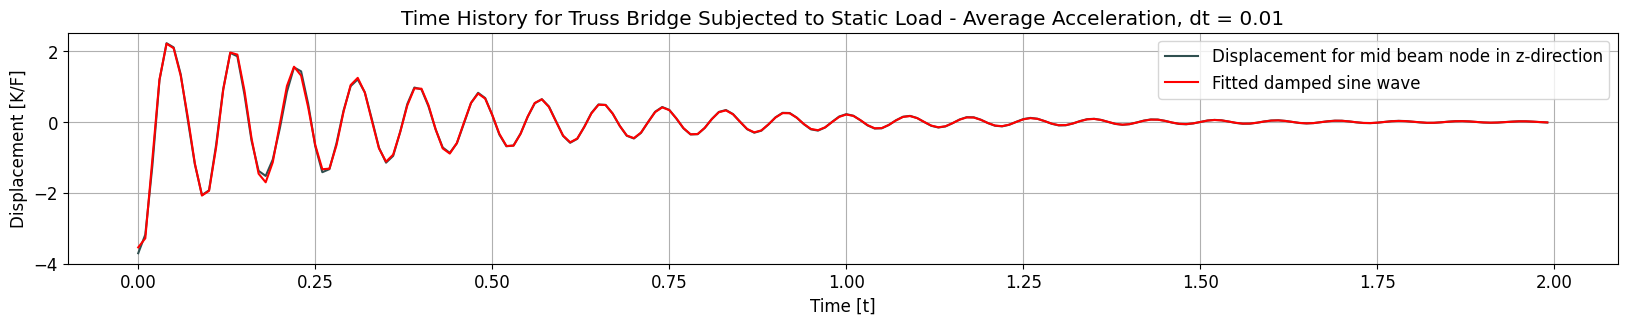

684


In [168]:
dt = 0.01
T = 2
time = np.arange(0,T,dt)
bridgenr = 10

#Check an example
print(*data_set[bridgenr].y[4].tolist())
fitted = damped_sine_wave_2(time, *data_set[bridgenr].y[4].tolist())
id = data_set[bridgenr].bridge_id
original = displacement_z_data[id][4]

title = 'Time History for Truss Bridge Subjected to Static Load - Average Acceleration, dt = '+str(dt)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(3)
plt.plot(time, original, color='darkslategrey', label='Displacement for mid beam node in z-direction')
plt.plot(time, fitted, 'r-', label='Fitted damped sine wave')
#plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
plt.xlabel('Time [t]')
plt.ylabel('Displacement [K/F]')
plt.grid()
plt.legend()
plt.title(title)
plt.show()

print(id)

In [153]:
import datetime
versj = 1
today = datetime.date.today().strftime("%b-%d")
print(today)

Jun-07


In [44]:
versj =2

In [154]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')

print("Using {}.".format(device_name))

Using cpu.


In [155]:
#Creating data sets

#80 percent training data
training_data = data_set[:int(len(data_set)*0.8)]
#10 percent validation data
validation_data = data_set[int(len(data_set)*0.8):int(0.9*len(data_set))]
#10 percent test data
test_data = data_set[int(0.9*len(data_set)):]
print(len(training_data))
print(len(validation_data))
print(len(test_data))
print(training_data[0].y.shape)
print(test_data[0])

1696
212
213
torch.Size([32, 8])
Data(x=[32, 4], edge_index=[2, 136], y=[32, 8], bridge_id=547)


In [156]:
#Definition of model

class TrussNN(torch.nn.Module):
    def __init__(self, in_channels, heads, t_inv = True):
        super(TrussNN, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 128, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.leaky_relu(self.fc0(x))
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = F.leaky_relu(self.conv4(x, edge_index))
        x = F.leaky_relu(self.conv5(x, edge_index))
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Truss2NN(torch.nn.Module):
    def __init__(self, in_channels, heads, t_inv = True):
        super(Truss2NN, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class TrussNN2(torch.nn.Module):
    def __init__(self, in_channels, heads, t_inv = True):
        super(TrussNN2, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.conv1 = feast_conv.FeaStConv(16, 32, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(512, 128, heads=heads, t_inv=t_inv)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 8)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.fc0(x))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        return x
    
class TrussNN3(torch.nn.Module):
    def __init__(self, in_channels, heads, t_inv = True):
        super(TrussNN3, self).__init__()
        self.fc0 = nn.Linear(in_channels, 16)
        self.fc1 = nn.Linear(16, 32)
        self.conv1 = feast_conv.FeaStConv(32, 64, heads=heads, t_inv=t_inv)
        self.conv2 = feast_conv.FeaStConv(64, 128, heads=heads, t_inv=t_inv)
        self.conv3 = feast_conv.FeaStConv(128, 256, heads=heads, t_inv=t_inv)
        self.conv4 = feast_conv.FeaStConv(256, 512, heads=heads, t_inv=t_inv)
        self.conv5 = feast_conv.FeaStConv(512, 1024, heads=heads, t_inv=t_inv)
        self.conv6 = feast_conv.FeaStConv(1024, 2048, heads=heads, t_inv=t_inv)
        self.conv7 = feast_conv.FeaStConv(2048, 4096, heads=heads, t_inv=t_inv)
        self.conv8 = feast_conv.FeaStConv(4096, 4096, heads=heads, t_inv=t_inv)
        self.conv9 = feast_conv.FeaStConv(4096, 2048, heads=heads, t_inv=t_inv)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 8)

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        self.conv4.reset_parameters()
        self.conv5.reset_parameters()
        self.conv6.reset_parameters()
        self.conv7.reset_parameters()
        self.conv8.reset_parameters()
        self.conv9.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.fc0(x))
        x = F.elu(self.fc1(x))
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))
        x = F.elu(self.conv5(x, edge_index))
        x = F.elu(self.conv6(x, edge_index))
        x = F.elu(self.conv7(x, edge_index))
        x = F.elu(self.conv8(x, edge_index))
        x = F.elu(self.conv9(x, edge_index))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = self.fc4(x)
        return x

In [159]:
import time
import torch
import torch.nn.functional as F


def print_info(info):
    message = ('Epoch: {}/{}, Duration: {:.3f}s,'
               'Train Loss: {:.4f}, Test Loss:{:.4f}').format(
                   info['current_epoch'], info['epochs'], info['t_duration'],
                   info['train_loss'], info['test_loss'])
    print(message)


def run(model, train_loader, test_loader, num_nodes, epochs, optimizer, device, model_path, train_path, test_path):
    train_losses = []
    test_losses = []

    # changed this for early saving limit
    min_loss = 850

    for epoch in range(1, epochs + 1):
        t = time.time()
        train_loss = train(model, train_loader, optimizer, device)
        t_duration = time.time() - t
        test_loss = test(model, test_loader, num_nodes, device)
        eval_info = {
            'train_loss': train_loss,
            'test_loss': test_loss,
            'current_epoch': epoch,
            'epochs': epochs,
            't_duration': t_duration
        }

        print_info(eval_info)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if test_loss < min_loss:
          np.savetxt(train_path, np.array(train_losses))
          np.savetxt(test_path, np.array(test_losses))
          torch.save(model.state_dict(), model_path)
          print("model is saved as ", model_path, " with test loss: ", test_loss)
          min_loss = test_loss
    
    return train_losses, test_losses

def train(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0
    for idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        # Calculate MSE loss for each item in output and labels
        losses = F.l1_loss(output, data.y.to(device))#, reduction='none')  
        # Compute mean loss for backpropagation
        loss = losses.mean()  
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def test(model, test_loader, num_nodes, device):
    model.eval()
    correct = 0
    total_loss = 0
    n_graphs = 0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            out = model(data.to(device))
            total_loss += F.l1_loss(out, data.y.to(device)).item()
    return total_loss / len(test_loader)

In [ ]:
#runner
num_nodes = training_data[0].x.shape[0]
num_features = training_data[0].x.shape[1]

model = TrussNN(num_features, heads=8).to(device_name)

optimizer = optim.Adam(model.parameters(),
                       lr=0.0001)


modelPath = "trained_models\\" + today + "_" + str(versj) + "TrussGNN_model_early" + ".pt"
trainLossPath = "trained_models\\" + today + "_" + str(versj) +  "TrussGNN_train_early" + ".txt"
testLossPath = "trained_models\\" + today + "_" + str(versj) +  "TrussGNN_test_early" + ".txt"

train_losses, test_losses = \
run(model, training_data, validation_data, num_nodes, 1000, optimizer, device_name, modelPath, trainLossPath, testLossPath)

#versj defined at the top of the notebook

modelPath = "trained_models\\" + today + "_" + str(versj) + "TrussGNN_model_early_final" + ".pt"
trainLossPath = "trained_models\\" + today + "_" + str(versj) +  "TrussGNN_train_early_final" + ".txt"
testLossPath = "trained_models\\" + today + "_" + str(versj) +  "TrussGNN_test_early_final" + ".txt"

np.savetxt(trainLossPath, np.array(train_losses))
np.savetxt(testLossPath, np.array(test_losses))
torch.save(model.state_dict(), modelPath)
versj += 1
print("saved as: ", modelPath)

In [163]:
model_best = TrussNN(num_features, heads=8).to(device_name)
model_dict_best = torch.load("trained_models\\Jun-01_1TrussGNN_model_early.pt", map_location=torch.device('cpu'))
model_best.load_state_dict(model_dict_best)
model_best.eval()
print(*test_data[0].y[12].tolist())

print(*model_best(test_data[0])[12].tolist())

3.4215383529663086 84.5576400756836 -2.065459966659546 3.437068462371826 2.171060800552368 -131.1251678466797 -1.215075969696045 28.768878936767578
3.254636764526367 85.41918182373047 -2.110112190246582 3.3680944442749023 2.1853320598602295 90.81736755371094 -1.8743427991867065 30.23197364807129


In [164]:
import time

start_time = time.perf_counter()

model_best(test_data[0])[12]

end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Program executed in: {execution_time:0.9f} seconds")  # where :0.9f gives 9 decimal places

Program executed in: 0.012578200 seconds


In [166]:
print(model_best(test_data[0])[9])
print(model_best(data_set_rising[0])[9])
print(data_set_rising[0].y[9])

tensor([  3.1810,  85.3487,  -2.1372,   3.4185,   2.2215, 128.8492,  -1.7824,
         26.7922], grad_fn=<SelectBackward0>)
tensor([  1.6442,  72.9333,  -1.8757,   2.9865,   0.3818, 113.1997,  -1.6156,
          9.3347], grad_fn=<SelectBackward0>)
tensor([  4.3986,  79.1574,  -2.0774,   3.9841,   1.9804, 113.5669,  -1.7018,
         17.8522])


200
0


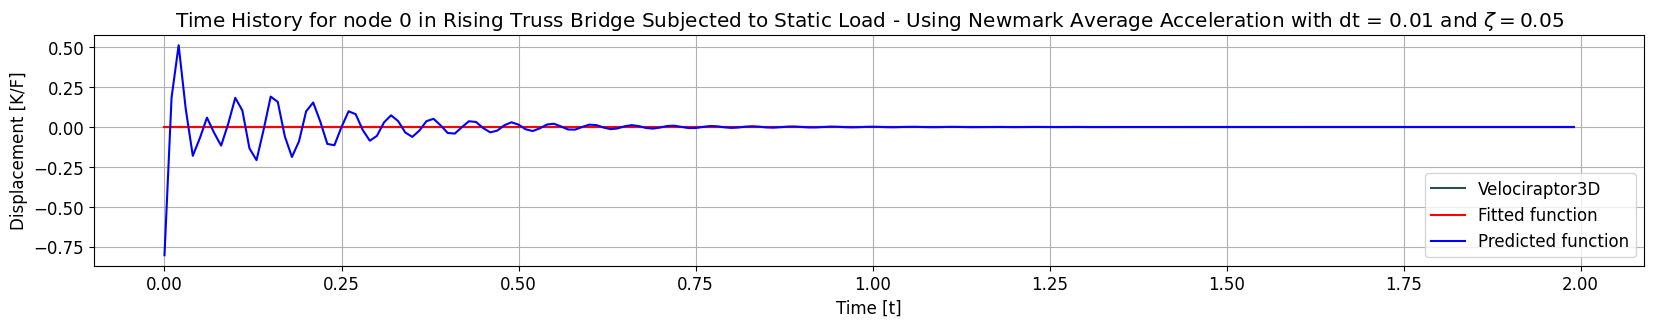

[0.42191529273986816, 111.07787322998047, -2.6860508918762207, 5.416959762573242, -1.0908520221710205, 130.23291015625, -3.7426211833953857, 18.67620086669922]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


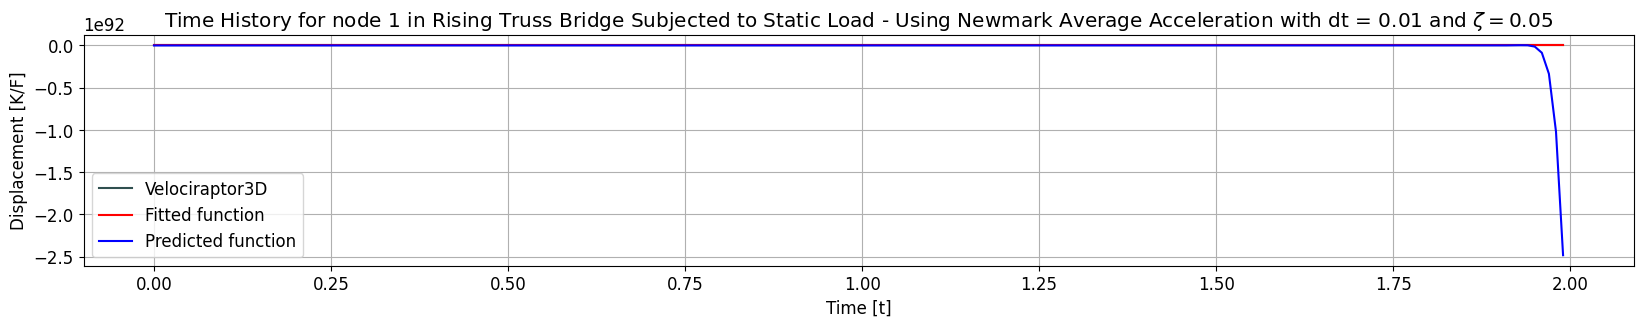

[1.6570935249328613, 72.18660736083984, -2.394362449645996, 5.774856090545654, -4.902385234832764, 45.795799255371094, -7.29940938949585, -106.19989013671875]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


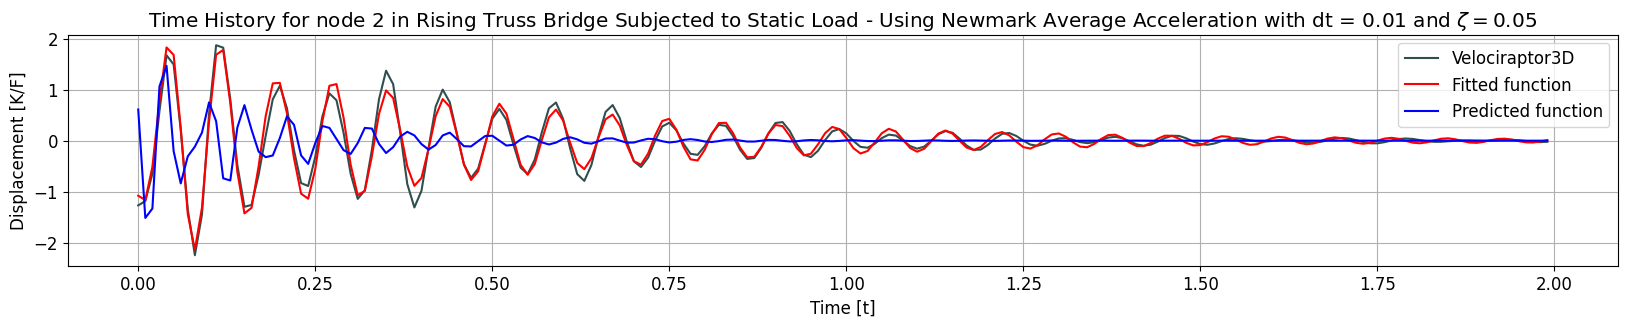

[1.1893011331558228, 110.24158477783203, -2.7543725967407227, 4.712921619415283, -1.0927975177764893, 172.0850830078125, -1.3238869905471802, 10.004146575927734]
[2.0257949829101562, 79.86297607421875, -1.5255237817764282, 2.033504009246826, -0.9924260973930359, 108.95040130615234, -1.263810634613037, 9.336783409118652]
0


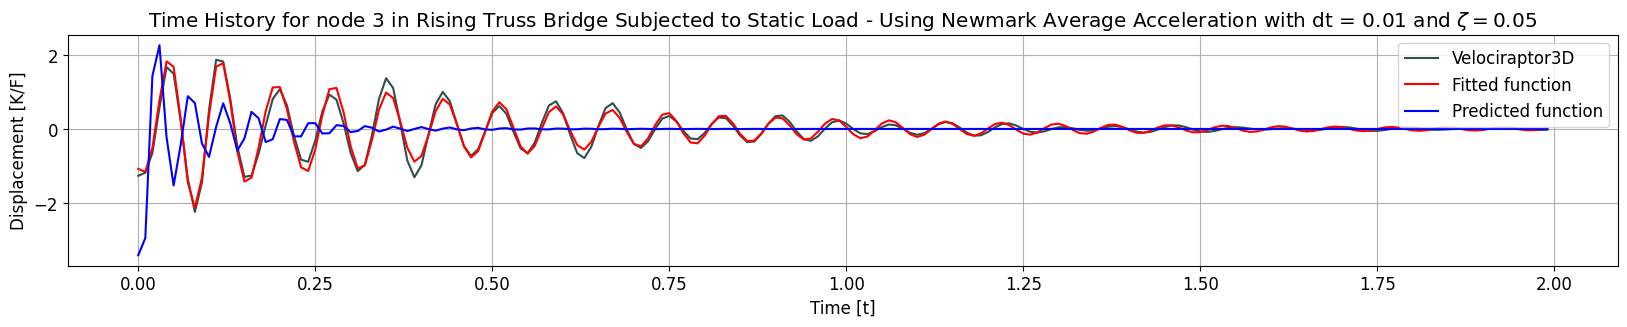

[-0.910038948059082, 161.40093994140625, -3.290891408920288, 7.034709453582764, -5.24418306350708, 142.53872680664062, -11.891252517700195, 17.660375595092773]
[2.0257949829101562, 79.86297607421875, -1.5255237817764282, 2.033504009246826, -0.9924260973930359, 108.95040130615234, -1.263810634613037, 9.336784362792969]
0


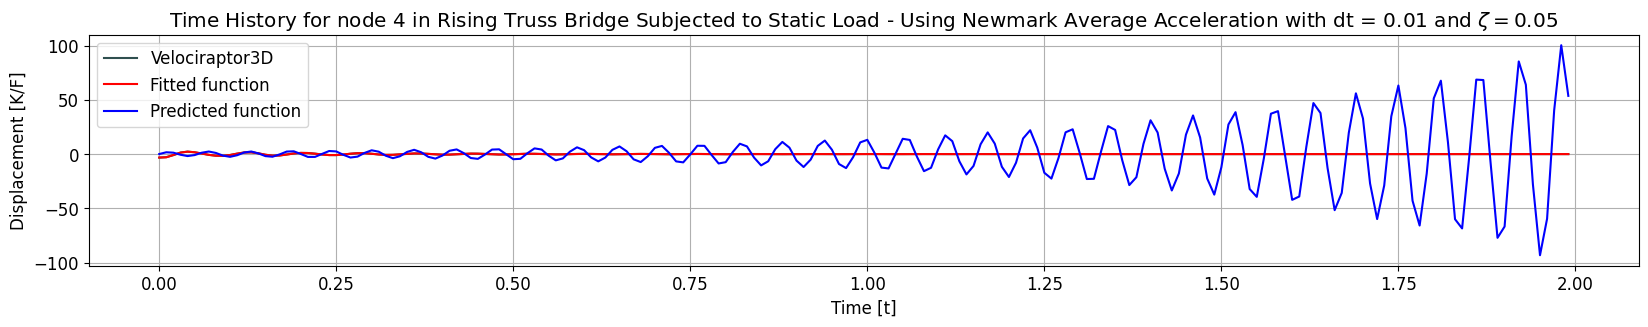

[-1.9429707527160645, 108.52357482910156, -2.8841288089752197, -1.993193507194519, 0.4872567653656006, 52.921199798583984, -7.396973133087158, 9.57201862335205]
[2.6964423656463623, 78.96360778808594, -2.028637170791626, 4.049593925476074, 0.8145044445991516, 119.94546508789062, -1.994813323020935, 11.95832347869873]
0


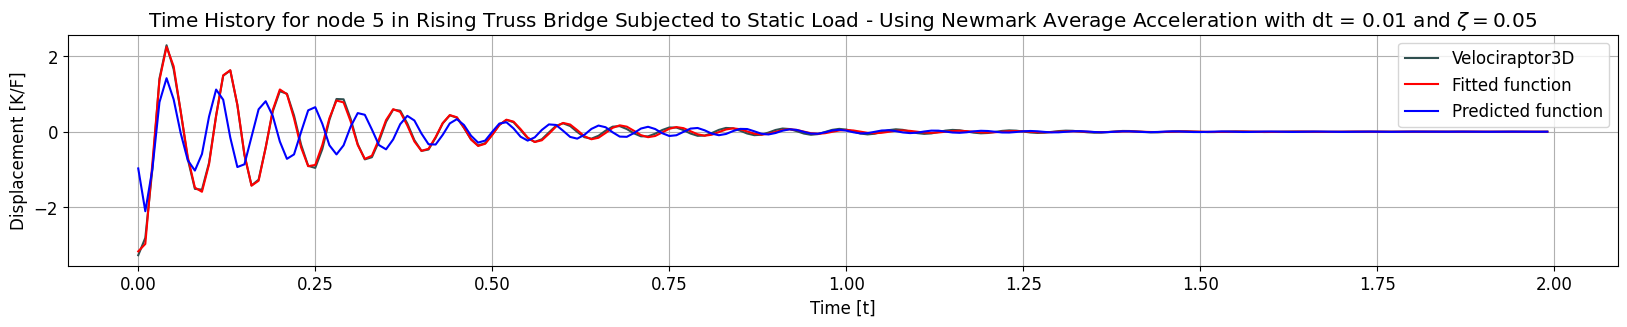

[1.5802875757217407, 93.0020980834961, -2.5257279872894287, 3.46122407913208, 0.6686990261077881, 145.48434448242188, -3.0567591190338135, 15.231818199157715]
[2.6964423656463623, 78.96360778808594, -2.028637170791626, 4.049593925476074, 0.8145044445991516, 119.94546508789062, -1.994813323020935, 11.95832347869873]
0


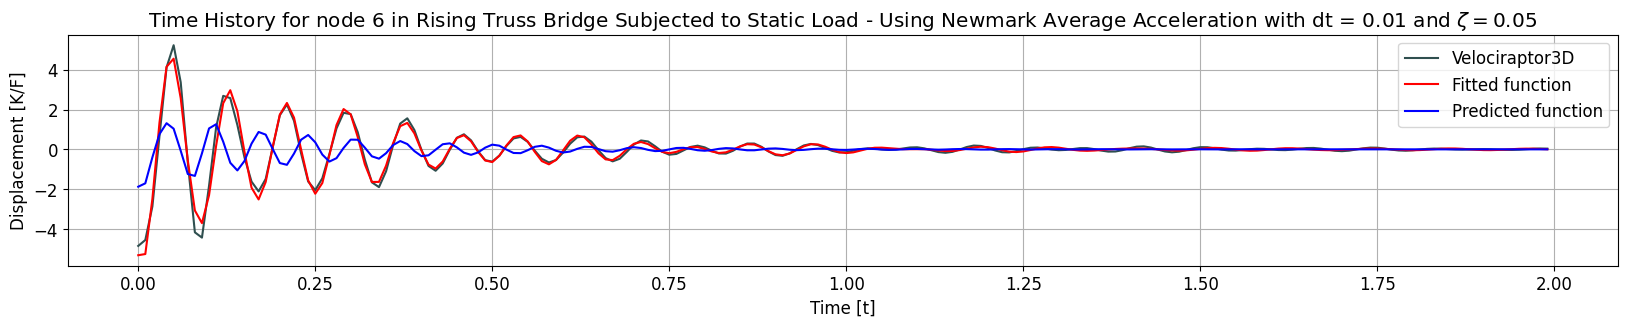

[1.930025577545166, 95.31922912597656, -2.388153076171875, 4.129150867462158, 0.5974442958831787, 146.0078125, -1.2073558568954468, 16.700044631958008]
[5.385467052459717, 76.28384399414062, -1.972071886062622, 3.777351140975952, -0.41888362169265747, 56.22023391723633, -5.223645210266113, 1.2542805671691895]
0


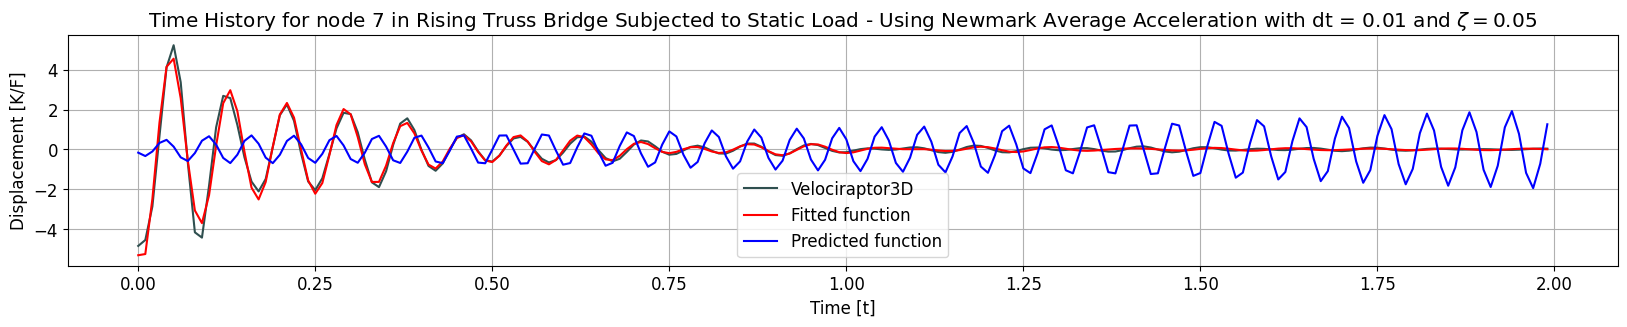

[0.5868411064147949, 105.89598846435547, -2.704092025756836, -0.6145831346511841, -0.3046247959136963, 88.3496322631836, -9.154888153076172, 10.348990440368652]
[5.385467052459717, 76.28384399414062, -1.972071886062622, 3.777351140975952, -0.41888365149497986, 56.22023391723633, -5.223645210266113, 1.254280686378479]
0


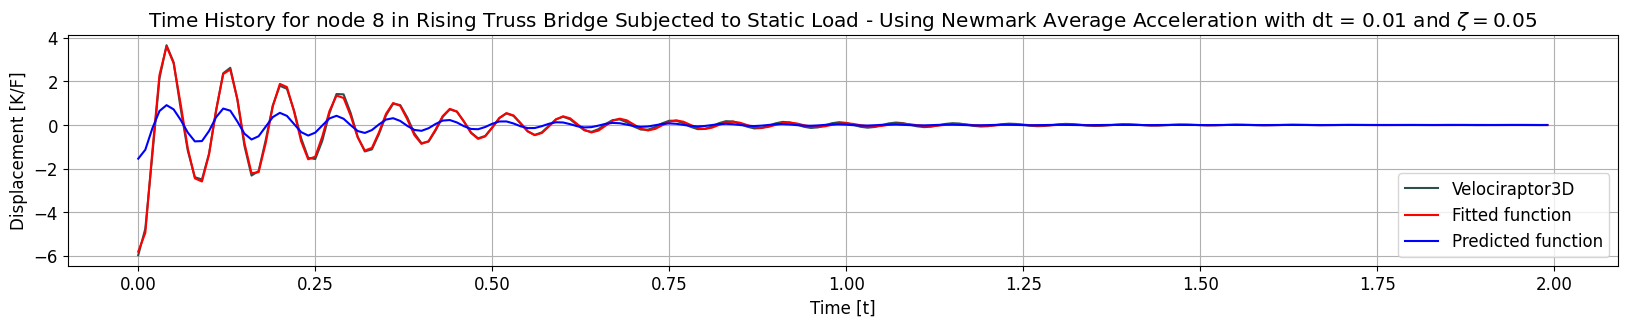

[1.1857603788375854, 79.98027801513672, -1.982313871383667, 3.694511890411377, 0.4651362895965576, 119.12689208984375, -1.392859697341919, 19.553083419799805]
[4.39860725402832, 79.15737915039062, -2.0773584842681885, 3.9841041564941406, 1.980351448059082, 113.56690216064453, -1.7018049955368042, 17.852216720581055]
0


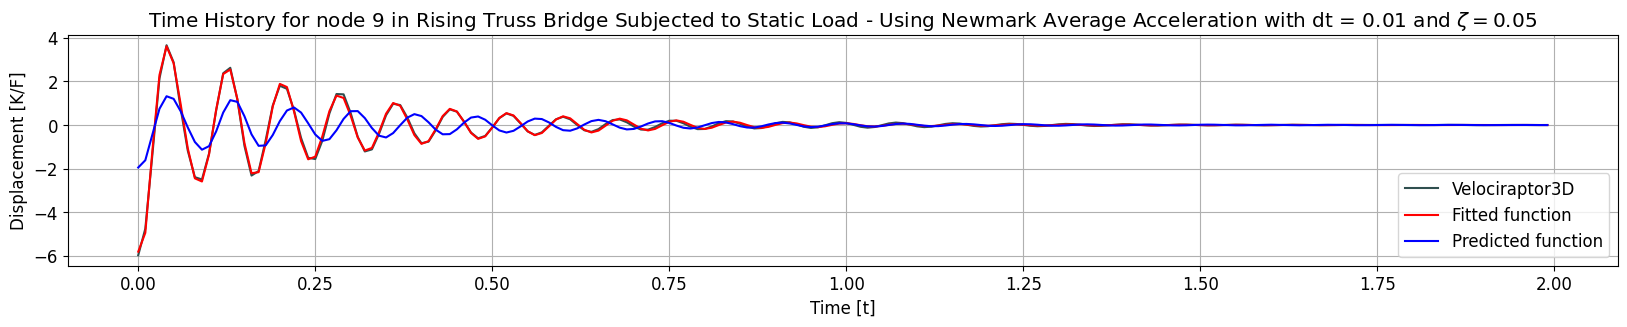

[1.6442396640777588, 72.9333267211914, -1.8756942749023438, 2.9864931106567383, 0.38179707527160645, 113.19967651367188, -1.6156411170959473, 9.334677696228027]
[4.39860725402832, 79.15737915039062, -2.0773584842681885, 3.9841041564941406, 1.980351448059082, 113.56690216064453, -1.7018049955368042, 17.852216720581055]
0


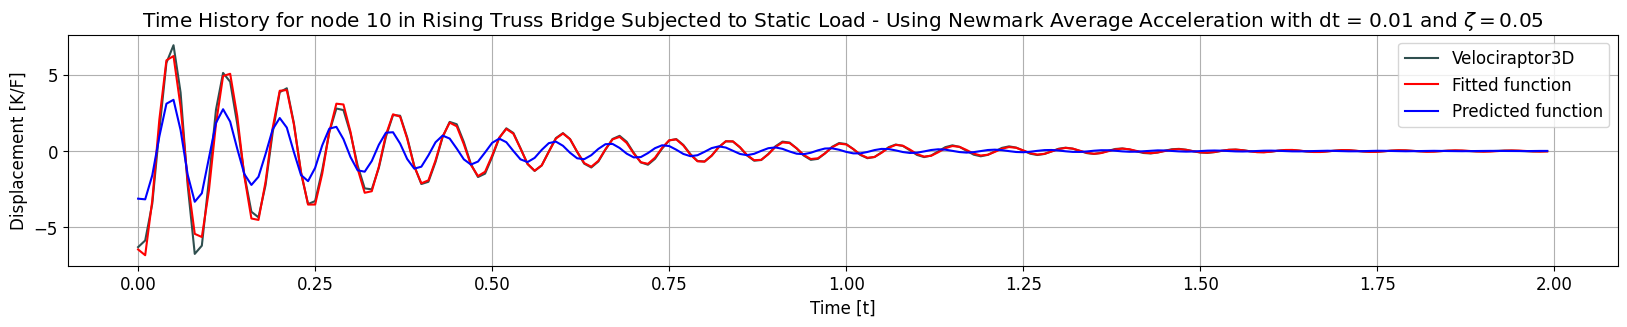

[4.0027594566345215, 80.88053131103516, -2.0213773250579834, 3.1339073181152344, -0.5942895412445068, 121.97352600097656, -2.2085537910461426, 7.073918342590332]
[6.5776686668396, 79.56427764892578, -2.1650373935699463, 2.6749067306518555, -1.042222261428833, 73.19481658935547, -4.464468002319336, 2.9857778549194336]
0


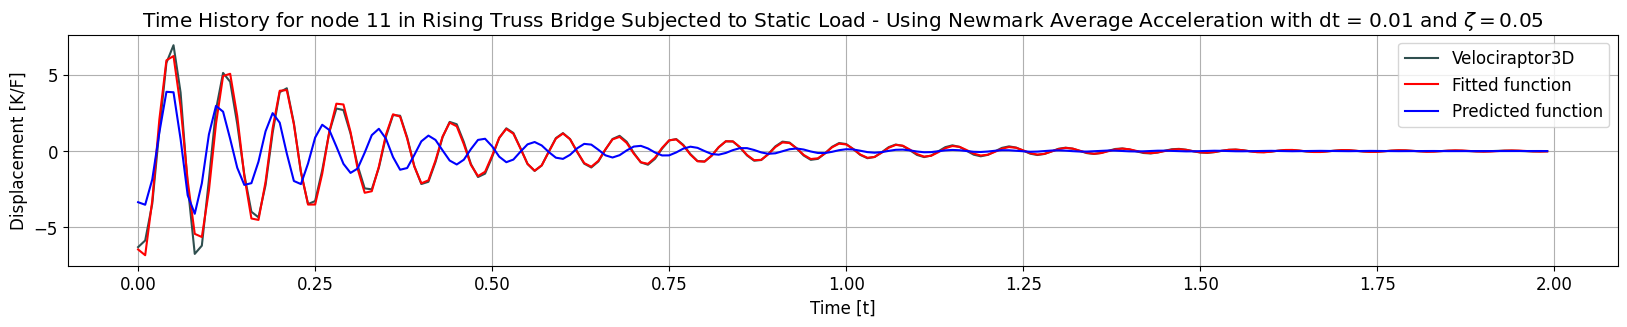

[4.722191333770752, 85.01734924316406, -2.0474507808685303, 3.623013973236084, -1.0013015270233154, 129.04086303710938, -2.15153431892395, 6.029796123504639]
[6.577669143676758, 79.56427764892578, -2.1650373935699463, 2.6749067306518555, -1.0422221422195435, 73.19481658935547, -4.464468002319336, 2.9857780933380127]
0


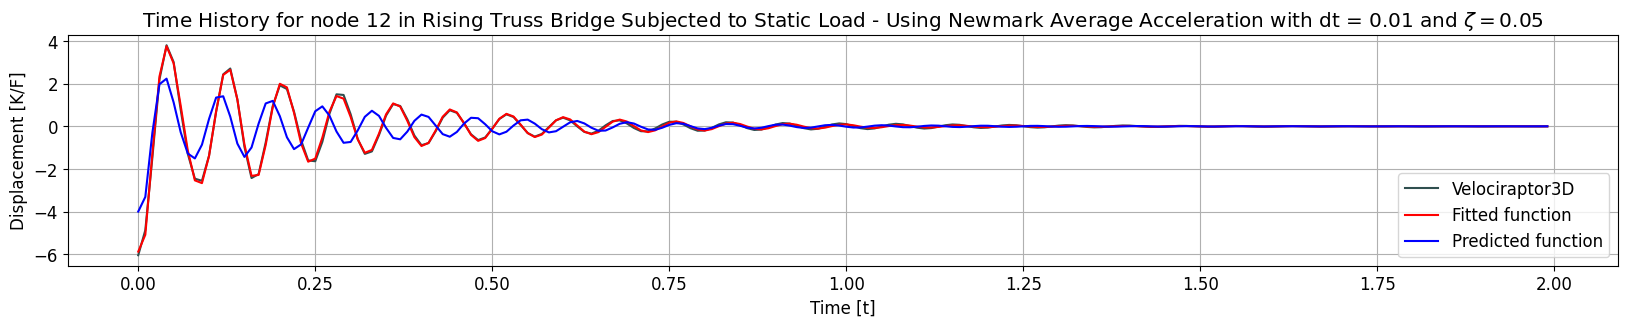

[2.4430489540100098, 87.26541900634766, -2.162609815597534, 3.654872417449951, 2.072486400604248, -120.01146697998047, -1.249701976776123, 23.64923858642578]
[4.548590183258057, 79.20805358886719, -2.0817172527313232, 3.919788122177124, 1.91989266872406, 113.01478576660156, -1.7002265453338623, 16.406448364257812]
0


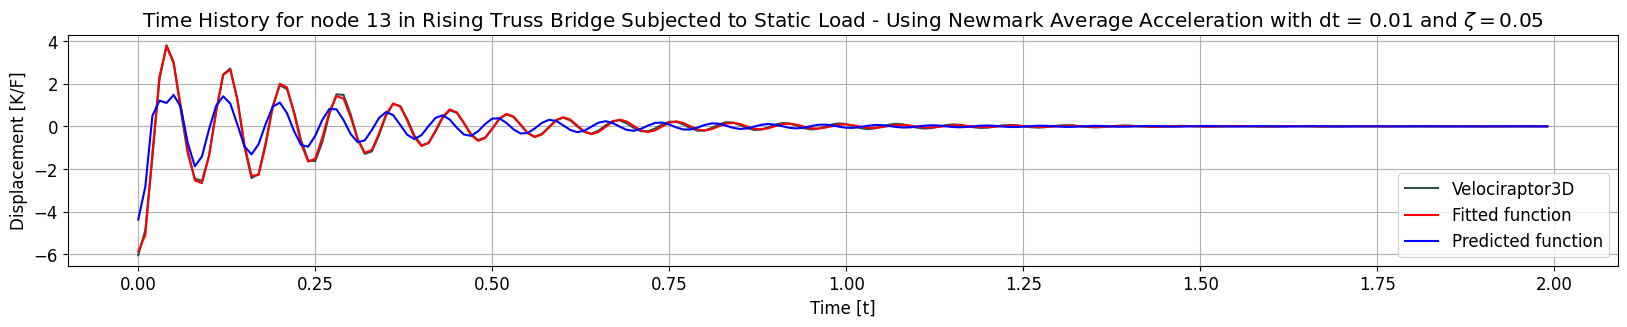

[2.2227182388305664, 81.64356994628906, -2.042194366455078, 3.3748483657836914, 2.6485955715179443, -158.72657775878906, -1.1276530027389526, 30.451231002807617]
[4.548590183258057, 79.20805358886719, -2.0817172527313232, 3.919788122177124, 1.9198927879333496, 113.01478576660156, -1.7002265453338623, 16.406448364257812]
0


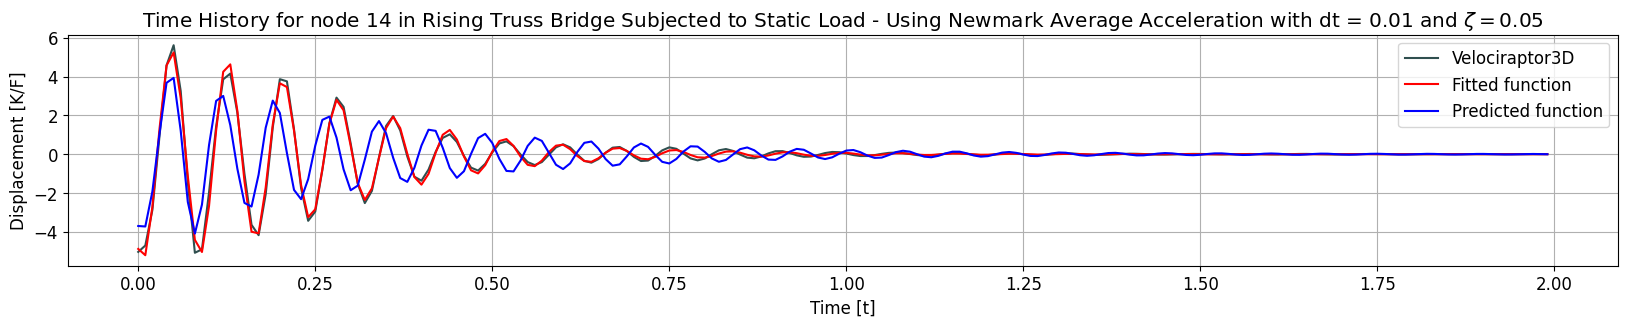

[4.73060941696167, 84.80009460449219, -2.1581003665924072, 3.030139923095703, -0.7735188007354736, 136.433837890625, -2.8293848037719727, 8.138866424560547]
[9.399897575378418, 79.13541412353516, -1.827852725982666, 4.8535332679748535, -4.209993839263916, 87.00853729248047, -1.5629901885986328, 7.290730953216553]
0


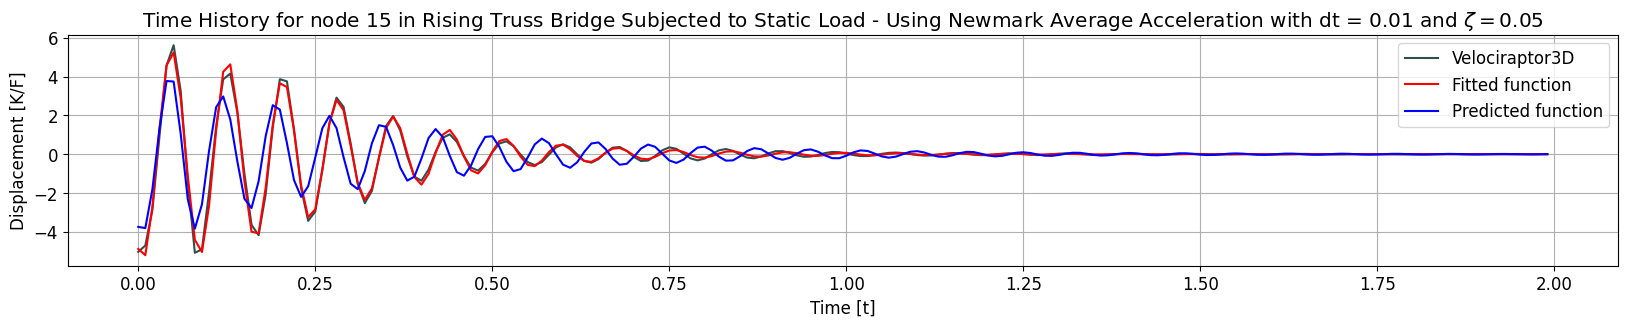

[4.604085445404053, 83.39845275878906, -2.0815749168395996, 3.0623779296875, -0.48978447914123535, 135.7943572998047, -2.555783748626709, 6.690410614013672]
[9.399897575378418, 79.13541412353516, -1.8278526067733765, 4.8535332679748535, -4.209994316101074, 87.00853729248047, -1.5629900693893433, 7.2907304763793945]
0


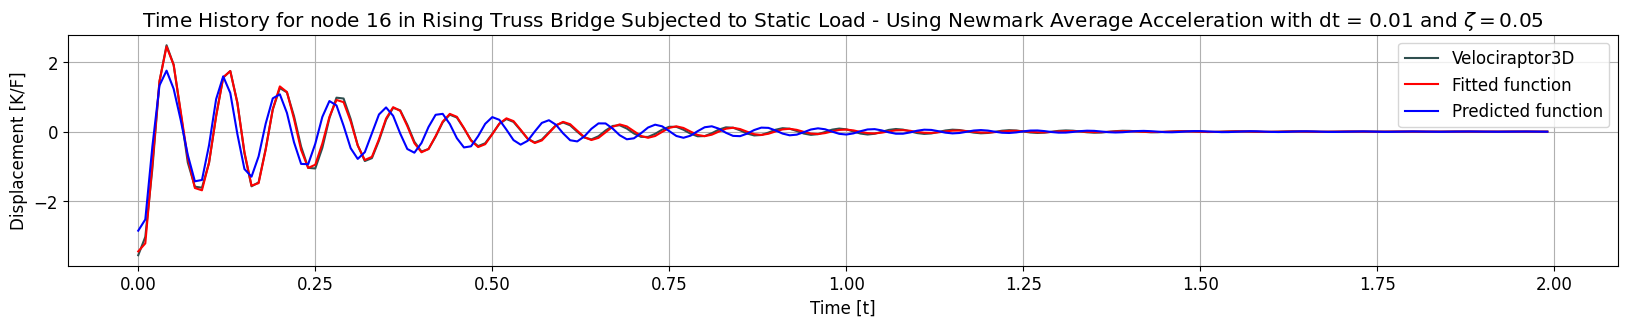

[2.181908369064331, 82.2558364868164, -2.0728840827941895, 3.2639923095703125, 1.0031392574310303, 129.60447692871094, -1.9523636102676392, 16.91250991821289]
[2.902104377746582, 79.14547729492188, -2.0565073490142822, 3.880046844482422, 0.9202814698219299, 116.02870178222656, -1.8946661949157715, 12.234635353088379]
0


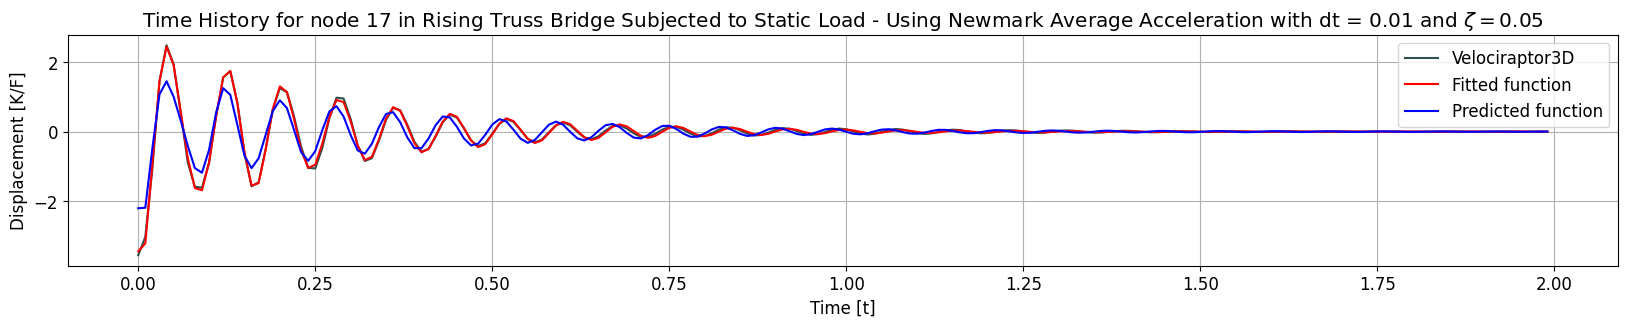

[1.7061047554016113, 80.67737579345703, -2.073770046234131, 3.021317481994629, 0.8943588733673096, 130.86880493164062, -2.2345731258392334, 16.66923713684082]
[2.902104377746582, 79.14547729492188, -2.0565073490142822, 3.880046844482422, 0.9202814698219299, 116.02870178222656, -1.8946661949157715, 12.234635353088379]
0


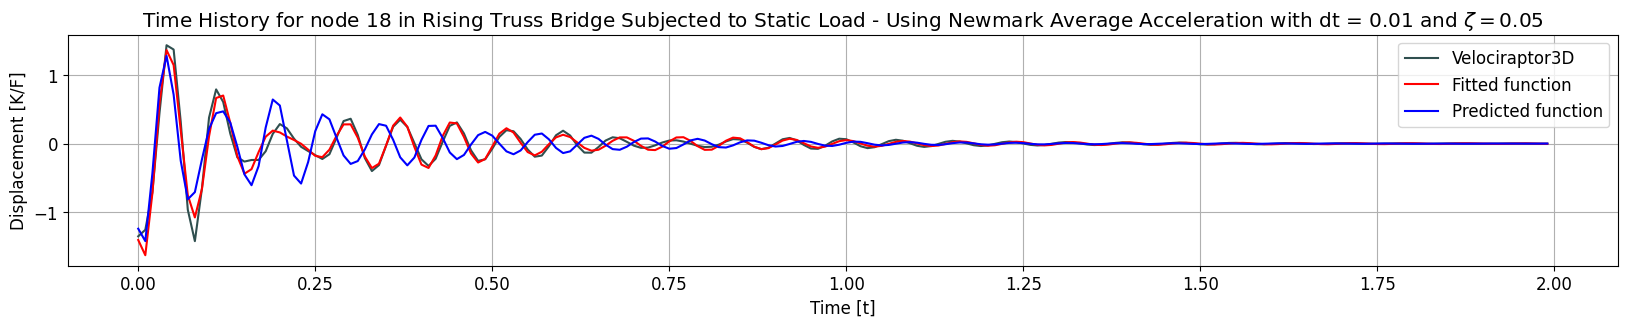

[1.0981642007827759, 84.01886749267578, -1.979109764099121, 3.5453567504882812, 0.49620604515075684, 116.50996398925781, -2.642089366912842, 6.16267204284668]
[0.7808185815811157, 78.99561309814453, -2.179690361022949, 2.6963419914245605, 0.9710460901260376, 93.37852478027344, -2.2255444526672363, 5.205651760101318]
0


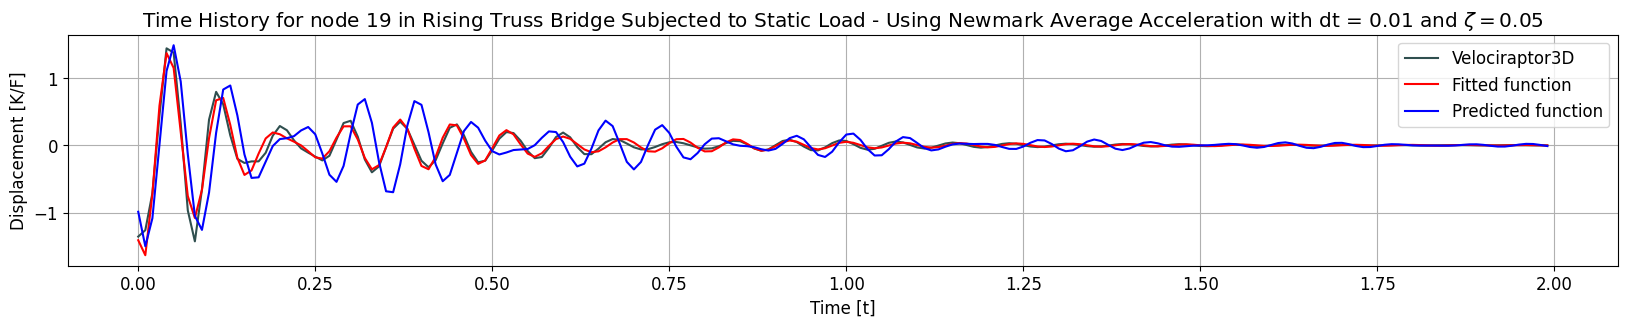

[0.9506754279136658, 72.31122589111328, -1.9842747449874878, 2.186901569366455, 0.7107360363006592, 91.7905502319336, -2.9752724170684814, 2.190702199935913]
[0.7808186411857605, 78.99561309814453, -2.179690361022949, 2.6963419914245605, 0.9710460305213928, 93.37852478027344, -2.2255444526672363, 5.205651760101318]
0


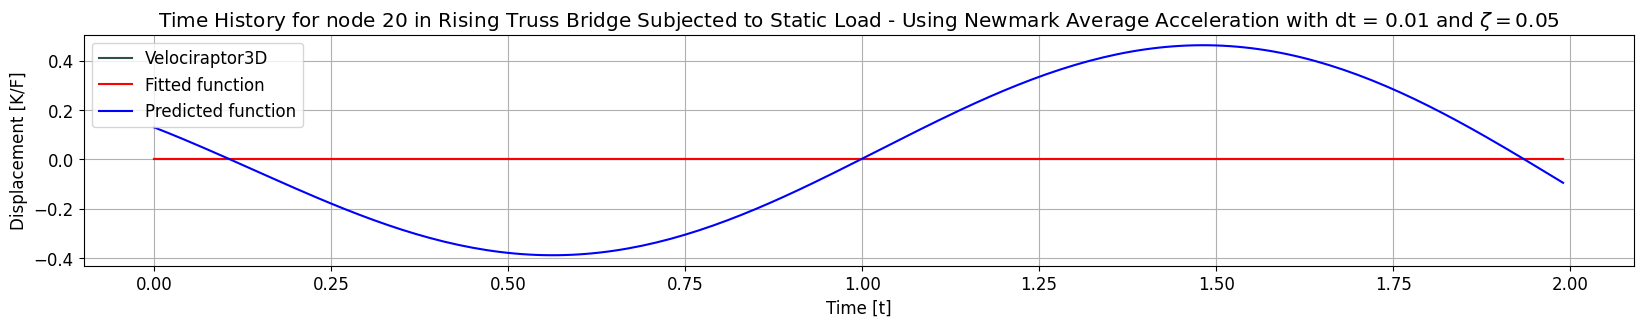

[-0.06567679345607758, 4.563365936279297, -0.17857815325260162, -0.02199713885784149, -0.2790132761001587, 3.429962158203125, -0.438883900642395, -0.3721988797187805]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


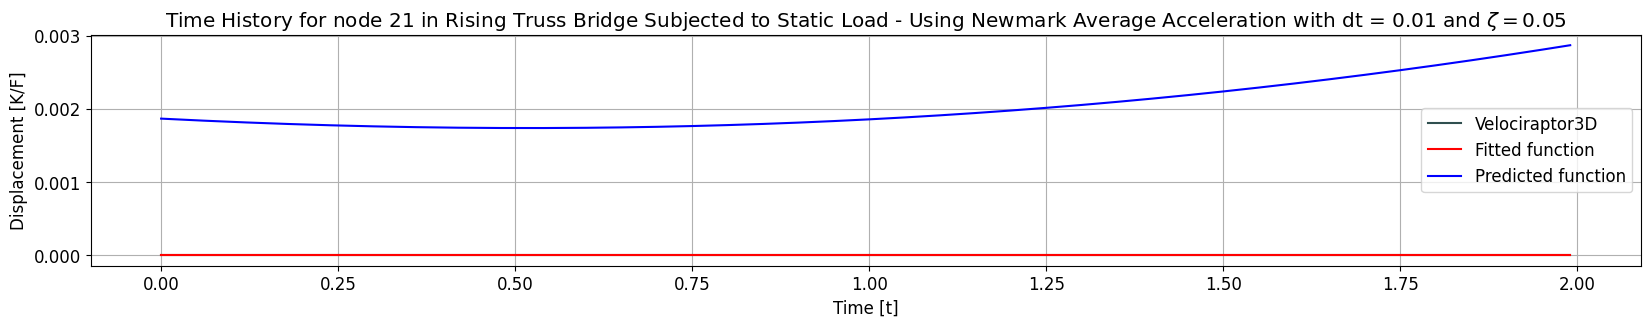

[-0.046133920550346375, -0.04653334617614746, -0.04864543676376343, -0.025072097778320312, 0.006809994578361511, -0.4027348756790161, -0.05531748756766319, 0.13207626342773438]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0


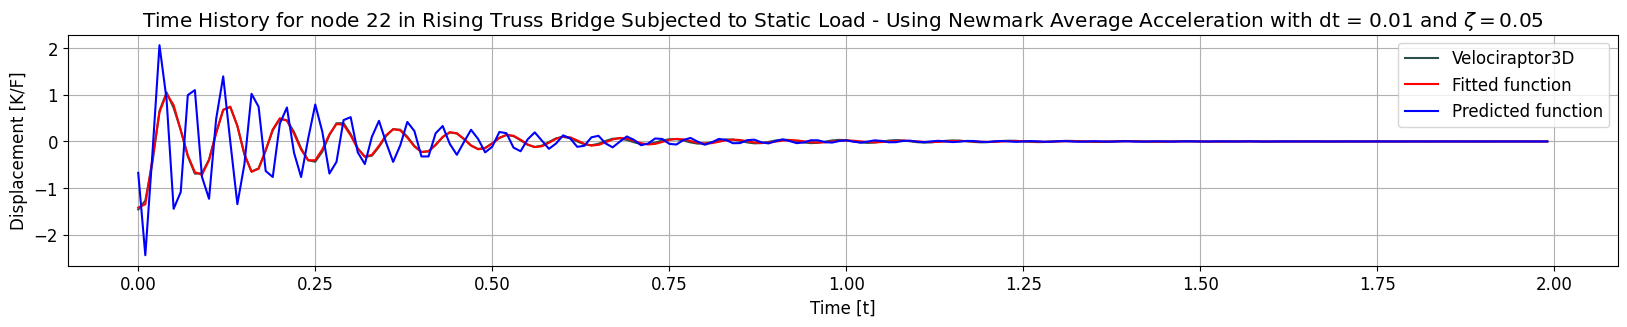

[0.28737956285476685, 94.58818817138672, -2.334679365158081, 4.738471508026123, -2.274379014968872, 142.95892333984375, 0.20616230368614197, 4.436735153198242]
[1.2219756841659546, 78.8875503540039, -2.0244226455688477, 4.059479713439941, 0.36066168546676636, 120.84467315673828, -2.049705982208252, 10.949938774108887]
0


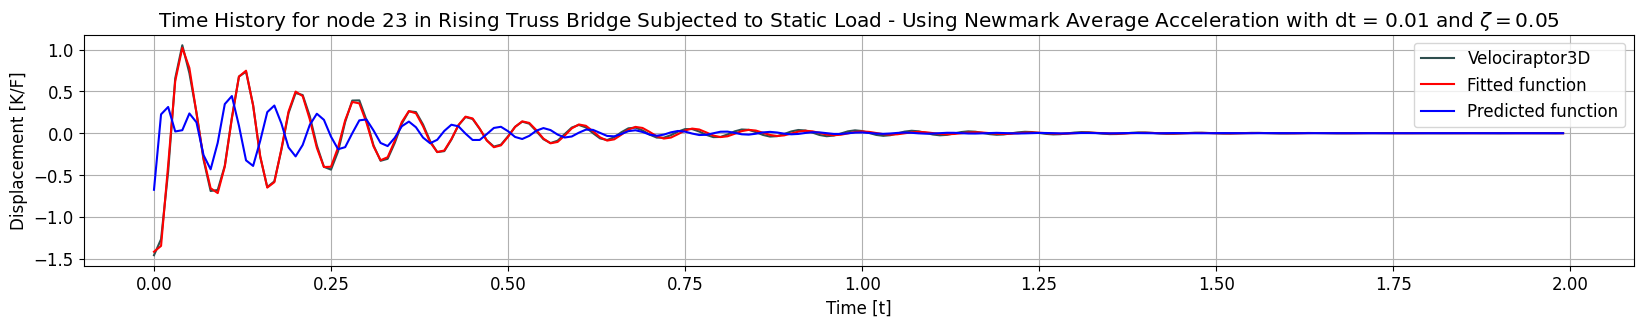

[0.6462637782096863, 98.53429412841797, -2.458190441131592, 4.27886438369751, -1.217886209487915, 125.72631072998047, -3.3644111156463623, 21.806299209594727]
[1.2219756841659546, 78.8875503540039, -2.0244226455688477, 4.059479713439941, 0.36066168546676636, 120.84467315673828, -2.049705982208252, 10.949938774108887]
0


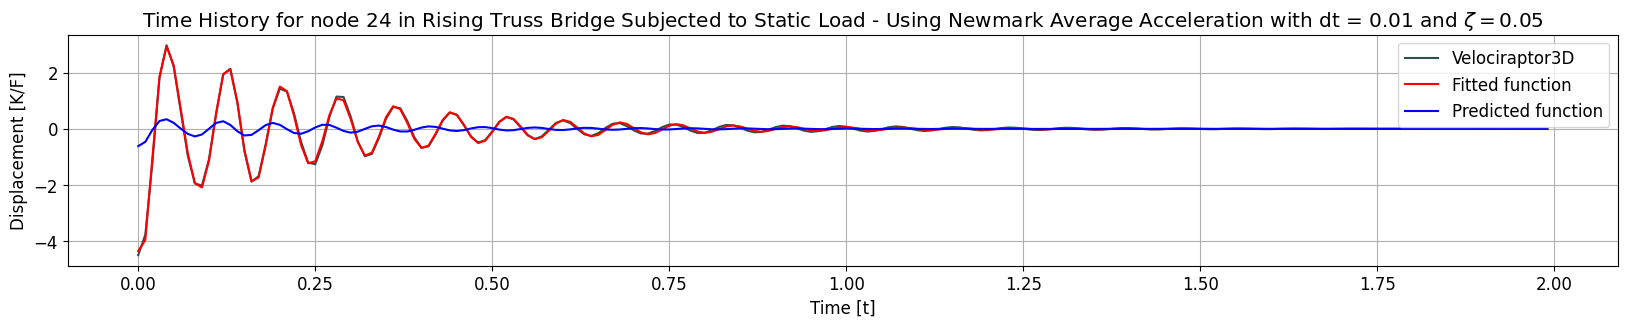

[0.43153995275497437, 85.12293243408203, -2.122255563735962, 3.835923194885254, 0.24586890637874603, 119.6702880859375, -1.526992678642273, 20.12227439880371]
[3.5463640689849854, 79.03971862792969, -2.0436108112335205, 4.015430450439453, 1.2504550218582153, 118.05284881591797, -1.8891032934188843, 13.65629768371582]
0


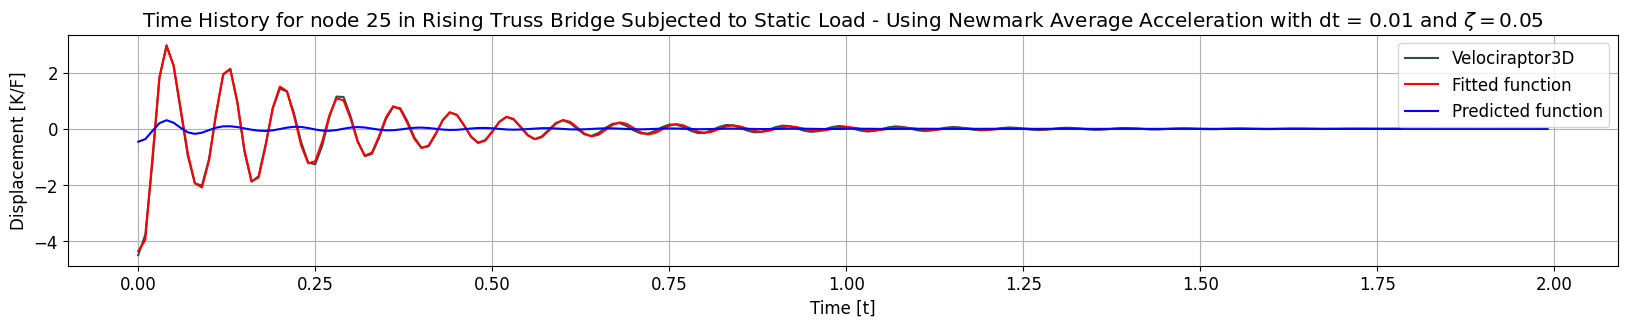

[0.17235760390758514, 71.13616943359375, -1.6711609363555908, 3.339751720428467, 0.30677008628845215, 90.39201354980469, -1.9558357000350952, 15.179336547851562]
[3.5463640689849854, 79.03971862792969, -2.0436108112335205, 4.015430450439453, 1.2504550218582153, 118.05284881591797, -1.8891032934188843, 13.65629768371582]
0


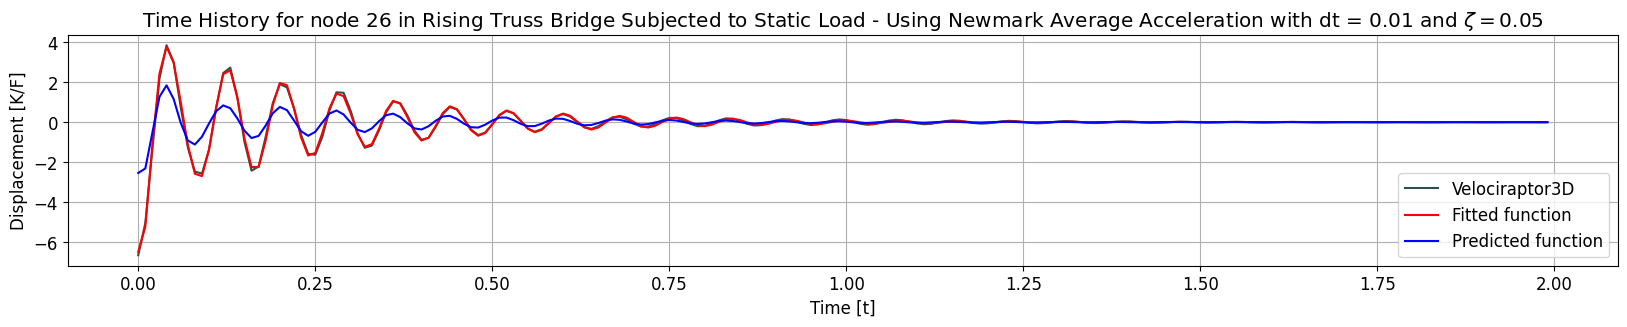

[1.5573809146881104, 79.93334197998047, -1.9581401348114014, 3.560427188873291, 1.2813136577606201, -105.09393310546875, -1.0374022722244263, 16.74466323852539]
[4.564681053161621, 79.2795181274414, -2.1073431968688965, 3.930959701538086, 2.5751395225524902, -110.03242492675781, -1.543964147567749, 21.213470458984375]
0


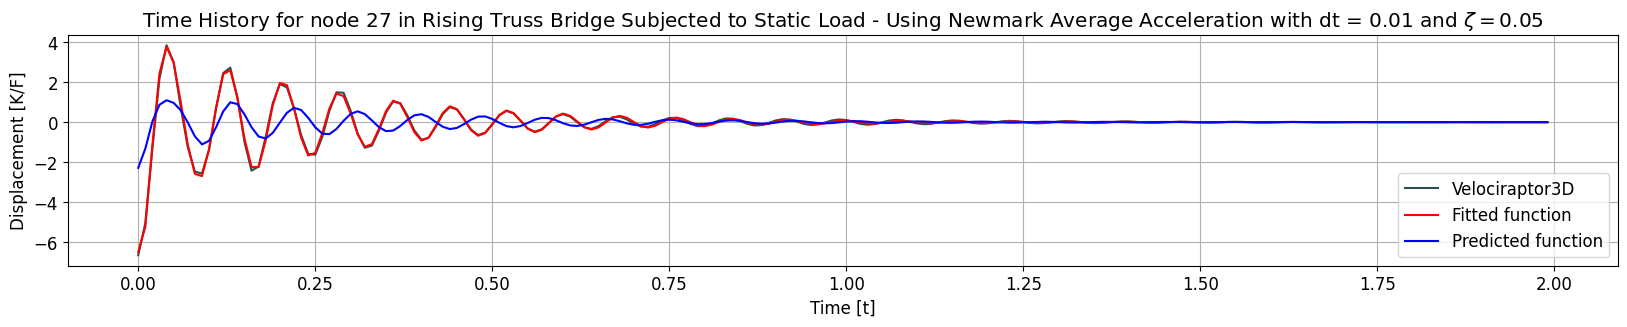

[1.5300253629684448, 71.41788482666016, -1.747542381286621, 3.350452423095703, 0.8276574611663818, 117.00958251953125, -1.2509254217147827, 21.0533447265625]
[4.564681053161621, 79.2795181274414, -2.1073431968688965, 3.930959701538086, 2.5751395225524902, -110.03242492675781, -1.543964147567749, 21.213470458984375]
0


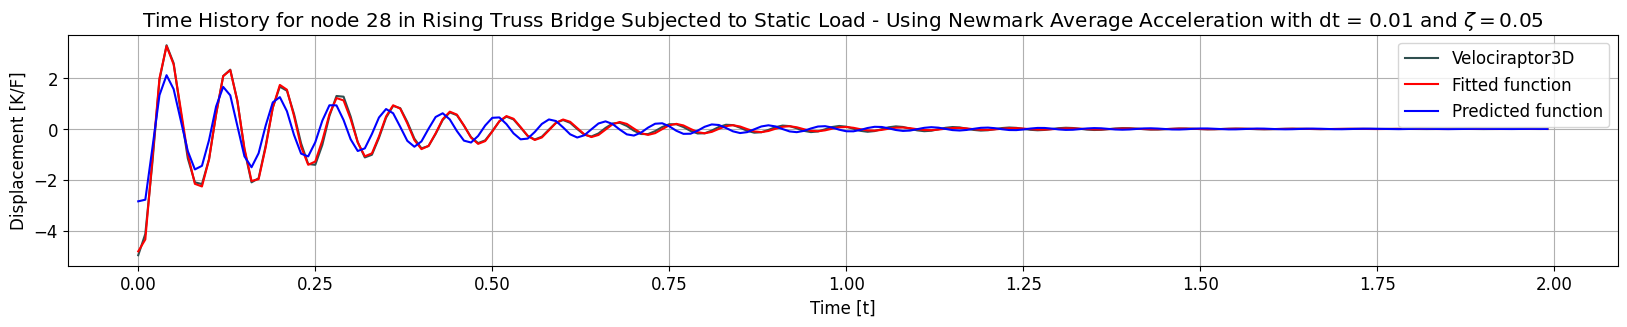

[2.411773681640625, 81.71156311035156, -2.072279453277588, 3.165966510772705, 0.8588154315948486, 123.6366958618164, -2.12148118019104, 16.819440841674805]
[3.902073860168457, 79.16626739501953, -2.06599497795105, 3.9052045345306396, 1.4218571186065674, 114.81926727294922, -1.806736707687378, 13.846108436584473]
0


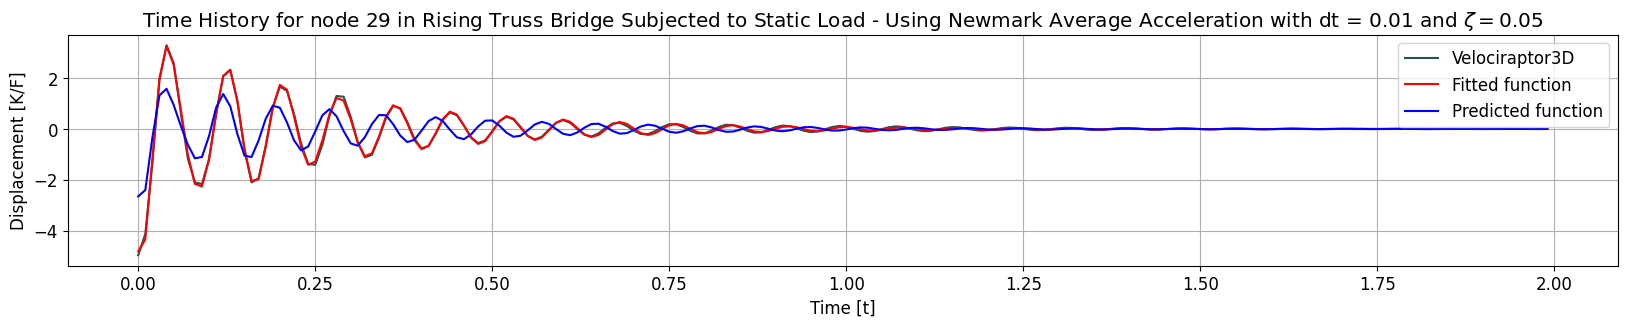

[1.892490267753601, 83.47295379638672, -2.113286018371582, 3.341550350189209, 1.1437032222747803, 128.0045623779297, -2.015458822250366, 16.73674774169922]
[3.902073860168457, 79.16626739501953, -2.06599497795105, 3.9052045345306396, 1.4218571186065674, 114.81926727294922, -1.806736707687378, 13.846108436584473]
0


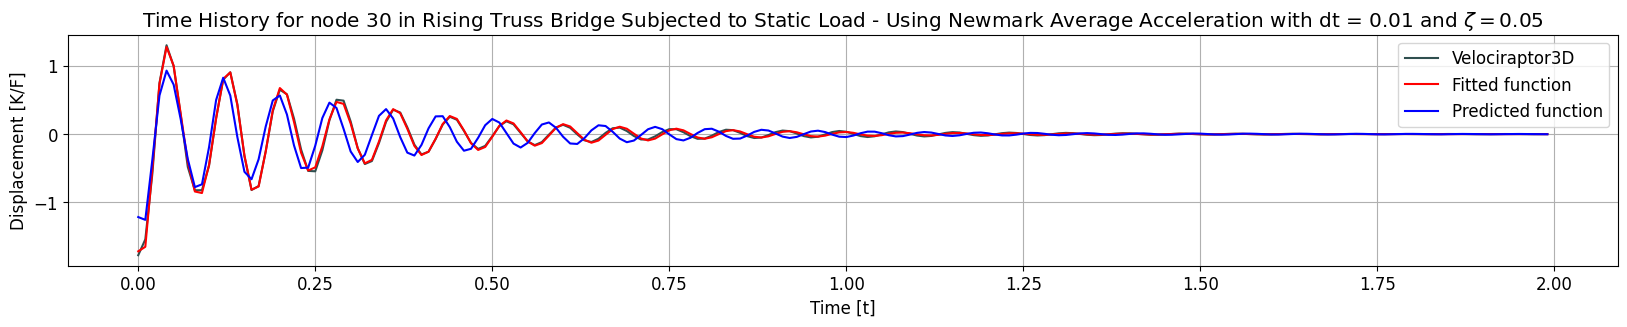

[1.137894868850708, 82.44673919677734, -2.1037187576293945, 3.2501792907714844, 0.29624199867248535, 134.1852569580078, -2.228321075439453, 13.47555160522461]
[1.4960421323776245, 79.12801361083984, -2.0459821224212646, 3.8607616424560547, 0.42502254247665405, 117.11920928955078, -2.0029358863830566, 10.738181114196777]
0


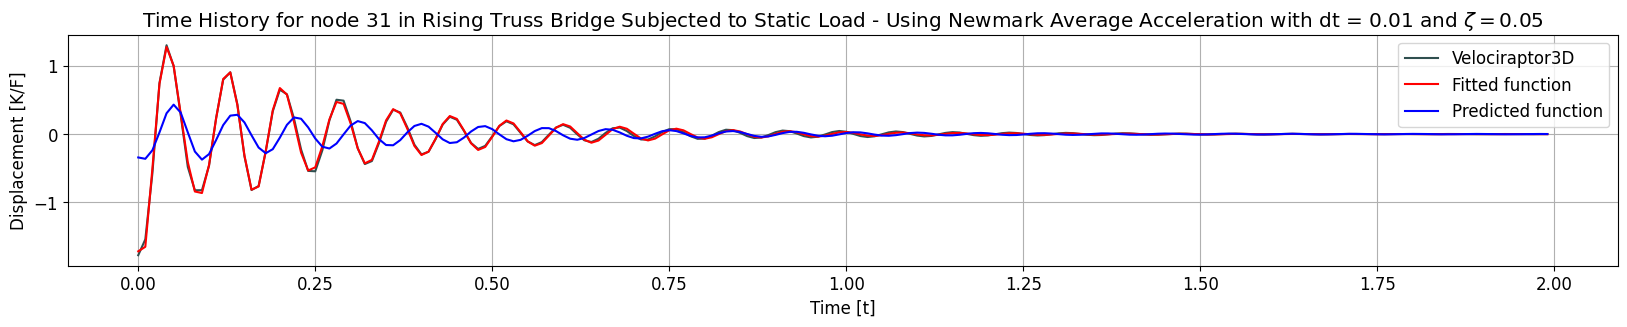

[0.45598089694976807, 71.6202163696289, -1.9343900680541992, 2.755031108856201, -0.0896151214838028, 116.33596801757812, -1.9155348539352417, 11.192229270935059]
[1.4960421323776245, 79.12801361083984, -2.0459821224212646, 3.8607616424560547, 0.42502251267433167, 117.11920928955078, -2.0029358863830566, 10.738180160522461]


In [167]:
dt = 0.01
T = 2
time = np.arange(0,T,dt)
print(len(time))
bridgenr = 0

for nodenr in range(0, len(data_set_rising[bridgenr].x)):
    labels = data_set_rising[bridgenr].y[nodenr].tolist()
    predicted_params1 = model_best(data_set_rising[bridgenr])[nodenr].tolist()

    fitted = damped_sine_wave_2(time, *labels)
    id = data_set_rising[bridgenr].bridge_id
    print(id)
    original = displacement_z_data_rising[id][nodenr]
    prediction_fitted1 = damped_sine_wave_2(time, *predicted_params1)


    title = 'Time History for node ' + str(nodenr) + ' in Rising Truss Bridge Subjected to Static Load - Using Newmark Average Acceleration with dt = '\
        +str(dt) + r' and $\zeta = 0.05$'
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(3)
    plt.plot(time, original, color='darkslategrey', label='Velociraptor3D')
    plt.plot(time, fitted, 'r-', label='Fitted function')
    plt.plot(time, prediction_fitted1, 'b-', label='Predicted function')
    #plt.scatter(time[maxAbsInd], disp[maxAbsInd], color='red', label='Max displacement = '+str(round(disp[maxAbsInd],8)))
    plt.xlabel('Time [t]')
    plt.ylabel('Displacement [K/F]')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

    print(predicted_params1)
    print(labels)

In [169]:
losses = []



for bridgenr in range(0, len(test_data)):
  loss = F.l1_loss(model_best(test_data[bridgenr]), test_data[bridgenr].y)
  losses.append(loss.item())
  #print('loss= ', loss)

losses = np.array(losses)
print("min loss: ", np.min(losses), " for bridge nr ", np.argmin(losses))
print(test_data[np.argmin(losses)].x[20])

print("max loss: ", np.max(losses), " for bridge nr ", np.argmax(losses))
print(test_data[np.argmax(losses)].x[20])

# Get three smallest values and indices
smallest_values = sorted(losses)[:3]
smallest_indices = sorted(range(len(losses)), key=losses.__getitem__)[:3]

# Get three highest values and indices
highest_values = sorted(losses, reverse=True)[:3]
highest_indices = sorted(range(len(losses)), key=losses.__getitem__, reverse=True)[:3]

id_best = test_data[smallest_indices[0]].bridge_id
id_worst = test_data[highest_indices[0]].bridge_id
original_best = displacement_z_data[id_best]
original_worst = displacement_z_data[id_worst]

np.savetxt("trained_models\\best_V3D_disp.txt", np.array(original_best).T)
print(original_best.shape)
np.savetxt("trained_models\\worst_V3D_disp.txt", np.array(original_worst).T)
print(original_worst.shape)

print("Smallest value:", smallest_values[0])
print("Bridge length: ", test_data[smallest_indices[0]].x[20][1]) # x value of node
print("Bridge height: ", test_data[smallest_indices[0]].x[26][3]) # z value of node
print("Bridge nr: ", smallest_indices[0])
#print("bridge dispdata: ", original)

print("2nd smallest value:", smallest_values[1])
print("Bridge length: ", test_data[smallest_indices[1]].x[20][1]) # x value of node
print("Bridge height: ", test_data[smallest_indices[1]].x[26][3]) # z value of node
print("Bridge nr: ", smallest_indices[1])

print("3rd smallest value:", smallest_values[2])
print("Bridge length: ", test_data[smallest_indices[2]].x[20][1]) # x value of node
print("Bridge height: ", test_data[smallest_indices[2]].x[26][3]) # z value of node
print("Bridge nr: ", smallest_indices[2])

print("Highest value:", highest_values[0])
print("Bridge length: ", test_data[highest_indices[0]].x[20][1]) # x value of node
print("Bridge height: ", test_data[highest_indices[0]].x[26][3]) # z value of node
print("Bridge nr: ", highest_indices[0])

print("2nd highest value:", highest_values[1])
print("Bridge length: ", test_data[highest_indices[1]].x[20][1]) # x value of node
print("Bridge height: ", test_data[highest_indices[1]].x[26][3]) # z value of node
print("Bridge nr: ", highest_indices[1])

print("3rd highest value:", highest_values[2])
print("Bridge length: ", test_data[highest_indices[2]].x[20][1]) # x value of node
print("Bridge height: ", test_data[highest_indices[2]].x[26][3]) # z value of node
print("Bridge nr: ", highest_indices[2]) 

dt = 0.01
T = 2
time = np.arange(0,T,dt)

predicted_displacements_best = []

predicted_displacements_worst = []

for i in range(0, 32):
  predicted_params = model_best(test_data[smallest_indices[0]])[i].tolist()
  prediction_fitted_best = damped_sine_wave_2(time, *predicted_params)
  predicted_displacements_best.append(prediction_fitted_best)
  predicted_params_worst = model_best(test_data[highest_indices[0]])[i].tolist()
  prediction_fitted_worst = damped_sine_wave_2(time, *predicted_params_worst)
  predicted_displacements_worst.append(prediction_fitted_worst)

np.savetxt("trained_models\\best_predictions.txt", np.array(predicted_displacements_best).T)
np.savetxt("trained_models\\worst_predictions.txt", np.array(predicted_displacements_worst).T)
print(np.array(predicted_displacements_best).shape)
print(np.array(predicted_displacements_worst).shape)

min loss:  0.5688092708587646  for bridge nr  122
tensor([2.0000e+01, 2.5700e+04, 0.0000e+00, 0.0000e+00])
max loss:  11441.2568359375  for bridge nr  208
tensor([2.0000e+01, 2.1100e+04, 0.0000e+00, 0.0000e+00])
(32, 200)
(32, 200)
Smallest value: 0.5688092708587646
Bridge length:  tensor(25700.)
Bridge height:  tensor(3500.)
Bridge nr:  122
2nd smallest value: 0.5714304447174072
Bridge length:  tensor(25600.)
Bridge height:  tensor(3500.)
Bridge nr:  8
3rd smallest value: 0.5947097539901733
Bridge length:  tensor(25300.)
Bridge height:  tensor(3600.)
Bridge nr:  196
Highest value: 11441.2568359375
Bridge length:  tensor(21100.)
Bridge height:  tensor(3500.)
Bridge nr:  208
2nd highest value: 6668.16259765625
Bridge length:  tensor(20900.)
Bridge height:  tensor(3700.)
Bridge nr:  28
3rd highest value: 5495.125
Bridge length:  tensor(21200.)
Bridge height:  tensor(4300.)
Bridge nr:  167
(32, 200)
(32, 200)


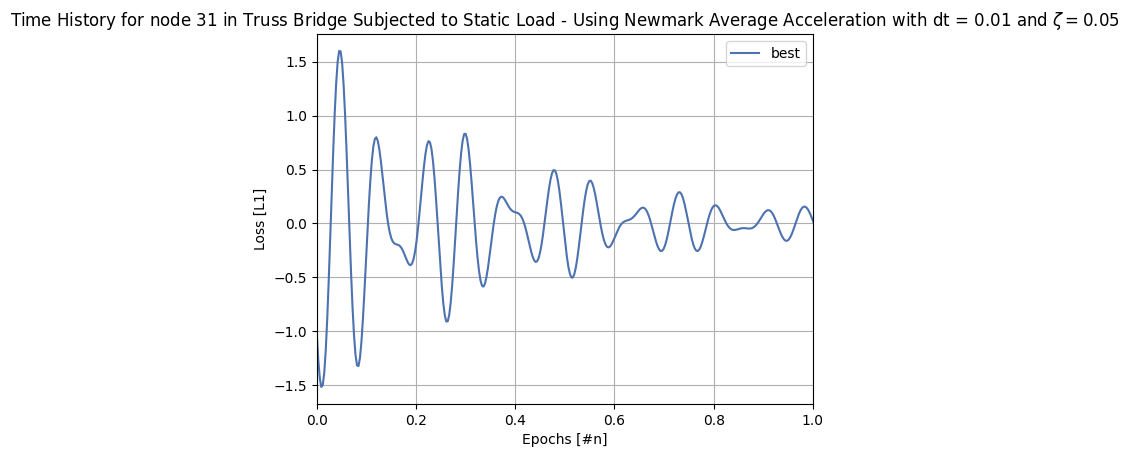

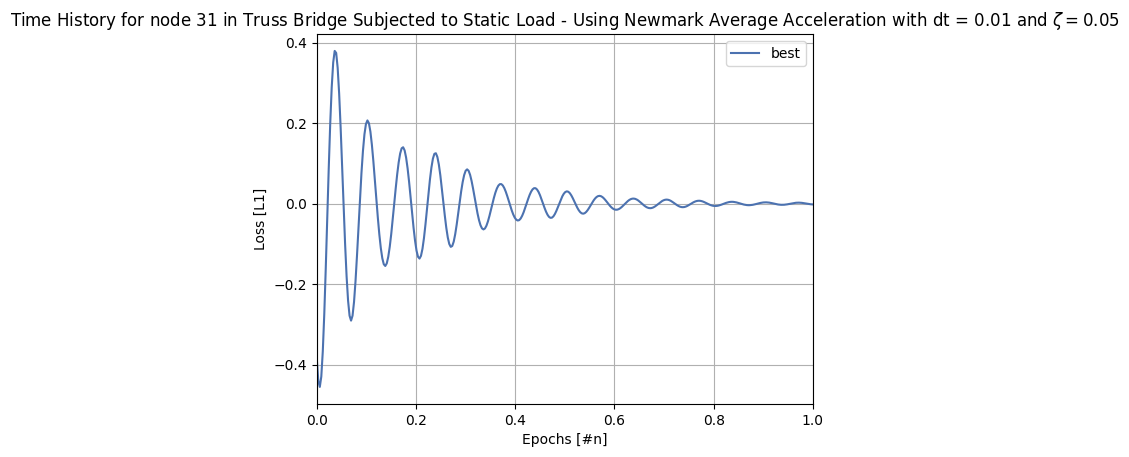

In [76]:
f = plt.figure()
plt.plot(time, predicted_displacements_best[2], color='#4C72B0', label='best')

plt.xlim(0,1)
#plt.ylim(0,50)
plt.xlabel('Epochs [#n]')
plt.ylabel('Loss [L1]')

plt.grid()
plt.legend()
plt.title(title)
plt.show()

f = plt.figure()
plt.plot(time, predicted_displacements_worst[2], color='#4C72B0', label='best')



plt.xlim(0,1)
#plt.ylim(-0.0016,0.001)
plt.xlabel('Epochs [#n]')
plt.ylabel('Loss [L1]')

plt.grid()
plt.legend()
plt.title(title)
plt.show()

node 0 best
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.11025042831897736, -0.3892683982849121, 0.0033027827739715576, -0.03140300512313843, -0.08317030966281891, -0.21166527271270752, -0.052450843155384064, 0.05720597505569458]
node 0 worst
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-0.024274364113807678, -0.266648530960083, -0.008535146713256836, -0.06484717130661011, 0.03742991387844086, -0.21670258045196533, -0.04544989764690399, 0.3360651135444641]
node 2 best
[1.2096874713897705, 74.74291229248047, -1.8914610147476196, 2.6640543937683105, 0.5205947756767273, 103.1626205444336, -3.006946086883545, 3.150277853012085]
[1.0959736108779907, 73.6155776977539, -1.8264691829681396, 2.4868898391723633, 0.714550256729126, 100.7980728149414, -3.1842174530029297, 2.467841863632202]
node 2 worst
[0.7376660108566284, 93.49815368652344, -2.064551830291748, 4.251935958862305, 0.225843146443367, 117.19637298583984, -2.3279776573181152, 7.371458530426025]
[0.3893100619316101, 94.30431365966797, -2

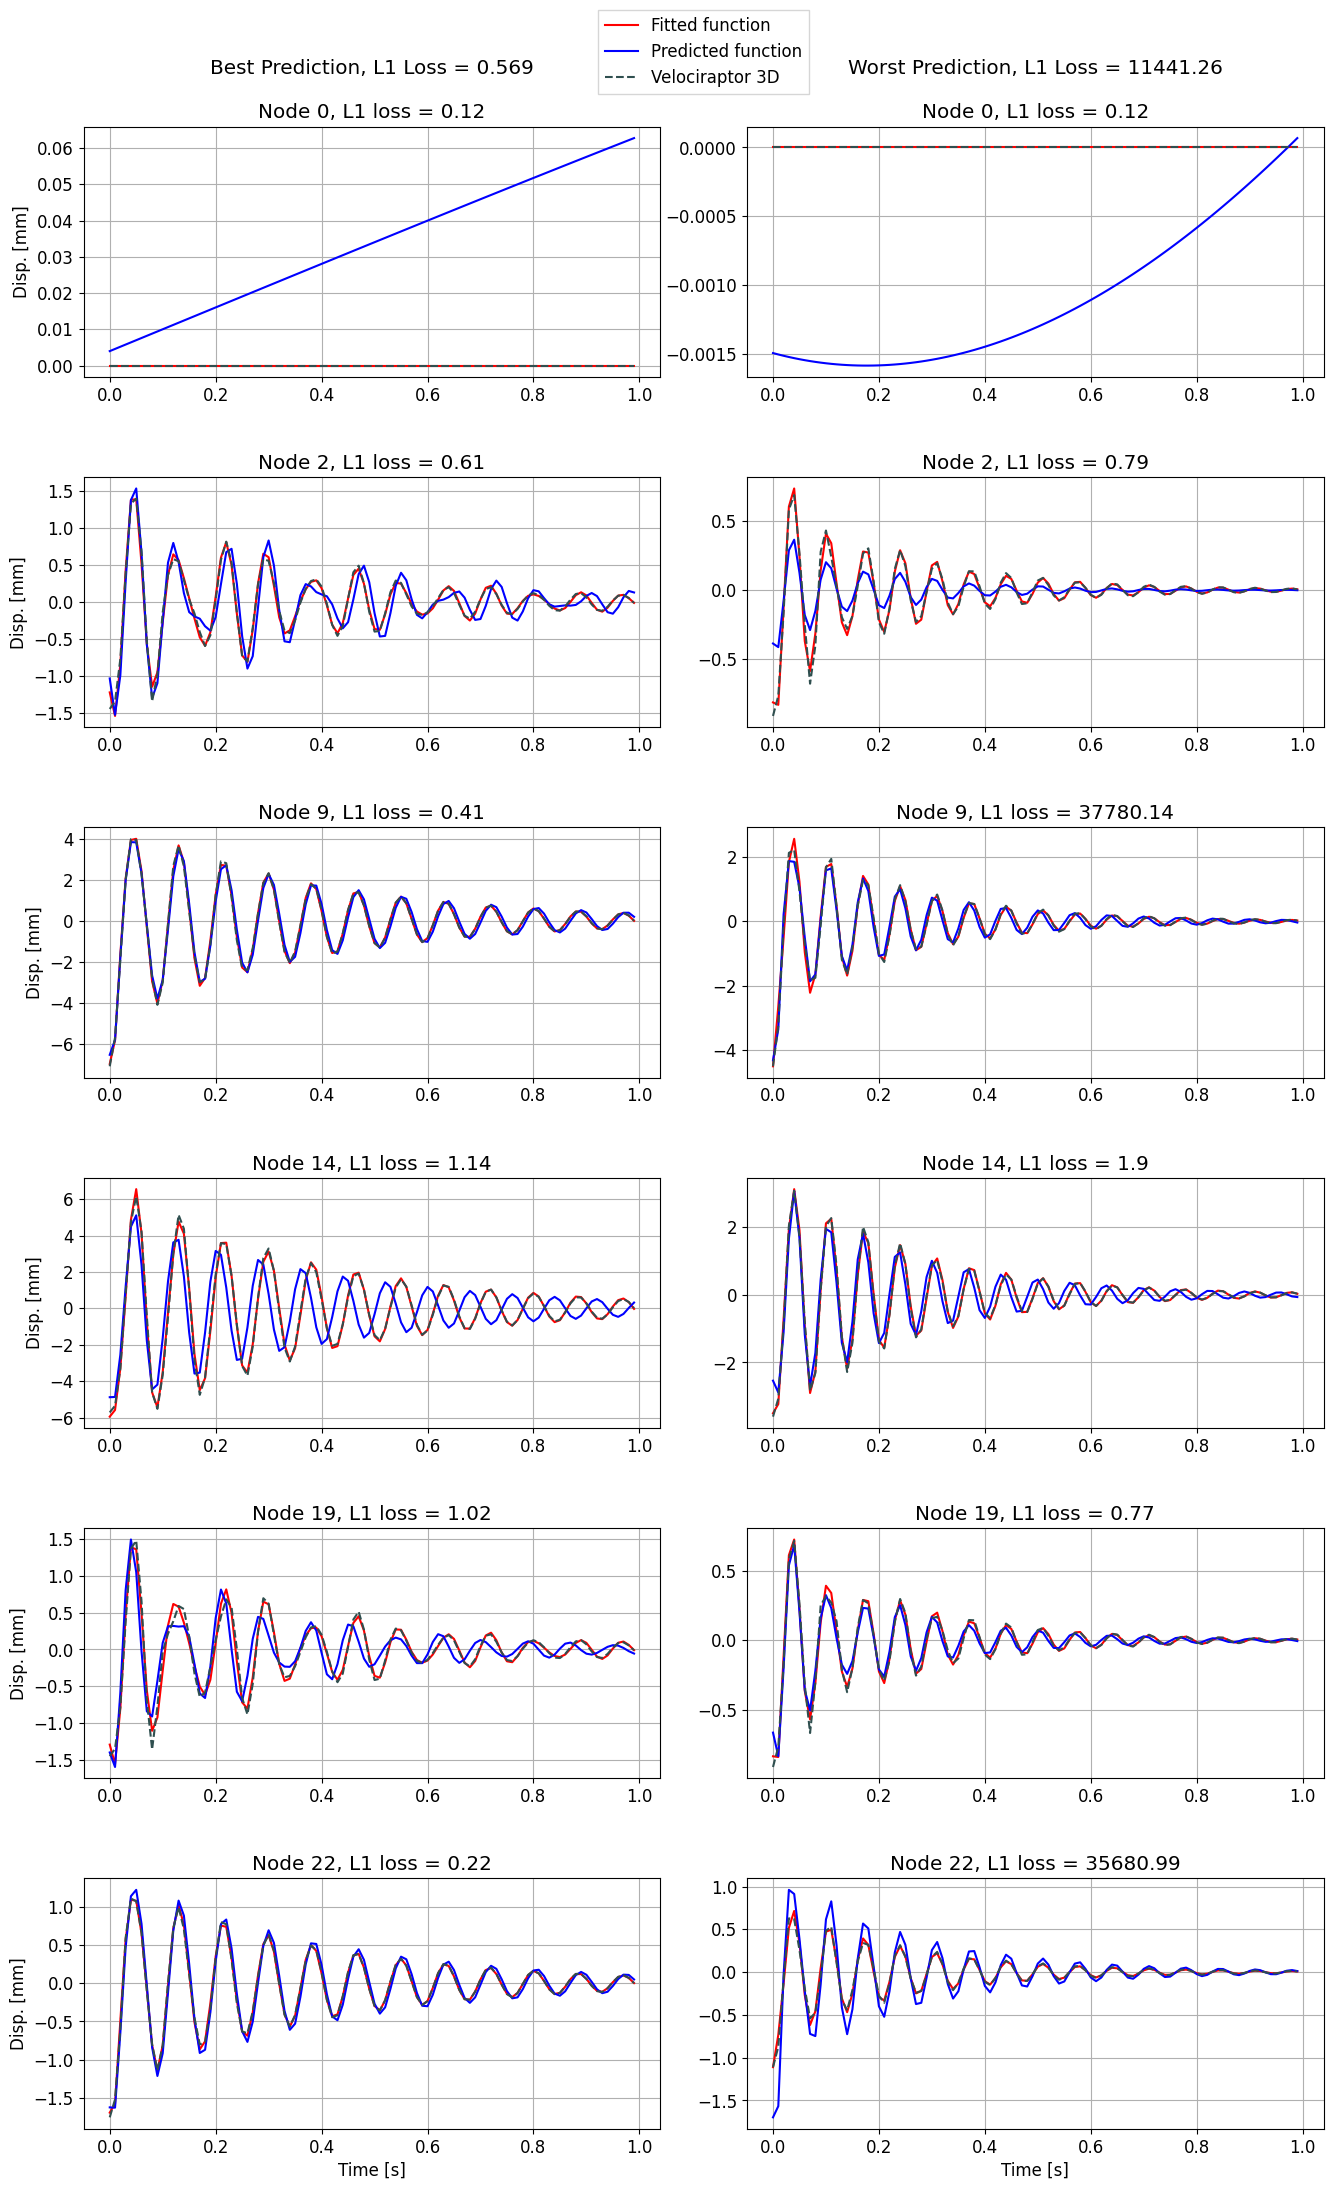

In [170]:
#Leaky vs Relu, for Herman

import matplotlib as mpl
mpl.get_configdir()


dt = 0.01
T = 1
time = np.arange(0,T,dt)
bridgenr = 122
bridgenr2 = 208

nodes = [0,2,9,14,19,22]

fig, axes = plt.subplots(len(nodes),2)
j = 0

fig.set_figheight(26)
fig.set_figwidth(16)

plt.rcParams['font.size'] = '12'
for i in nodes:

    ##best

    loss = round(F.l1_loss(model_best(test_data[bridgenr])[i], test_data[bridgenr].y[i]).item(), 2)

    labels = test_data[bridgenr].y[i].tolist()
    predicted_params = model_best(test_data[bridgenr])[i].tolist()
    id = test_data[bridgenr].bridge_id
    original = displacement_z_data[id][i][:100]

    fitted = damped_sine_wave_2(time, *labels)

    id = test_data[bridgenr].bridge_id
    prediction_fitted = damped_sine_wave_2(time, *predicted_params)

    if (j == 0):
        axes[j,0].set_title('Best Prediction, L1 Loss = 0.569'+'\n'+'\n'+'Node '+str(i)+", L1 loss = "+str(loss))
    else:
        axes[j,0].set_title('Node '+str(i)+", L1 loss = "+str(loss))


    axes[j,0].plot(time, fitted, 'r-', label='Fitted function')
    axes[j,0].plot(time, prediction_fitted, 'b-', label='Predicted function')
    axes[j,0].plot(time, original, color='darkslategrey', linestyle='--', label='Velociraptor 3D')
    #axes[j,0].set_title('Trained with MSE, Node '+str(i))

    axes[j,0].set_ylabel('Disp. [mm]')
    axes[j,0].grid()
    #axes[j,0].legend(loc="lower right")   
    axes[0,0].legend(loc='upper center', bbox_to_anchor=(1.075, 1.5),
          fancybox=False, shadow=False, ncol=1)  

    if (j == len(nodes)-1):
        axes[j,0].set_xlabel('Time [s]')

    print('node '+str(i)+' best')
    print(labels)
    print(predicted_params)
    
    # worst

    loss = round(F.l1_loss(model_best(test_data[bridgenr2])[i], test_data[bridgenr2].y[i]).item(), 2)

    labels = test_data[bridgenr2].y[i].tolist()
    predicted_params = model_best(test_data[bridgenr2])[i].tolist()
    id = test_data[bridgenr2].bridge_id
    original = displacement_z_data[id][i][:100]

    fitted = damped_sine_wave_2(time, *labels)

    id = test_data[bridgenr].bridge_id
    prediction_fitted = damped_sine_wave_2(time, *predicted_params)

    if (j == 0):
        axes[j,1].set_title('Worst Prediction, L1 Loss = 11441.26'+'\n'+'\n'+'Node '+str(i)+", L1 loss = "+str(loss))
    else:
        axes[j,1].set_title('Node '+str(i)+", L1 loss = "+str(loss))


    axes[j,1].plot(time, fitted, 'r-', label='Fitted function')
    axes[j,1].plot(time, prediction_fitted, 'b-', label='Predicted function')
    axes[j,1].plot(time, original, color='darkslategrey', linestyle='--', label='Velociraptor 3D')
    #axes[j,0].set_title('Trained with MSE, Node '+str(i))

    #axes[j,1].set_ylabel('Disp. [mm]')
    axes[j,1].grid()
    #axes[j,1].legend(loc="lower right")     

    if (j == len(nodes)-1):
        axes[j,1].set_xlabel('Time [s]')
   
    print('node '+str(i)+' worst')
    print(labels)
    print(predicted_params)

    j+=1



# Show the figure with subplots
plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.4)
plt.show()



node 0 best
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.42191529273986816, 111.07787322998047, -2.6860508918762207, 5.416959762573242, -1.0908520221710205, 130.23291015625, -3.7426211833953857, 18.67620086669922]
node 2 best
[2.0257949829101562, 79.86297607421875, -1.5255237817764282, 2.033504009246826, -0.9924260973930359, 108.95040130615234, -1.263810634613037, 9.336783409118652]
[1.1893011331558228, 110.24158477783203, -2.7543725967407227, 4.712921619415283, -1.0927975177764893, 172.0850830078125, -1.3238869905471802, 10.004146575927734]
node 9 best
[4.39860725402832, 79.15737915039062, -2.0773584842681885, 3.9841041564941406, 1.980351448059082, 113.56690216064453, -1.7018049955368042, 17.852216720581055]
[1.6442396640777588, 72.9333267211914, -1.8756942749023438, 2.9864931106567383, 0.38179707527160645, 113.19967651367188, -1.6156411170959473, 9.334677696228027]
node 16 best
[2.902104377746582, 79.14547729492188, -2.0565073490142822, 3.880046844482422, 0.9202814698219299, 116.02870

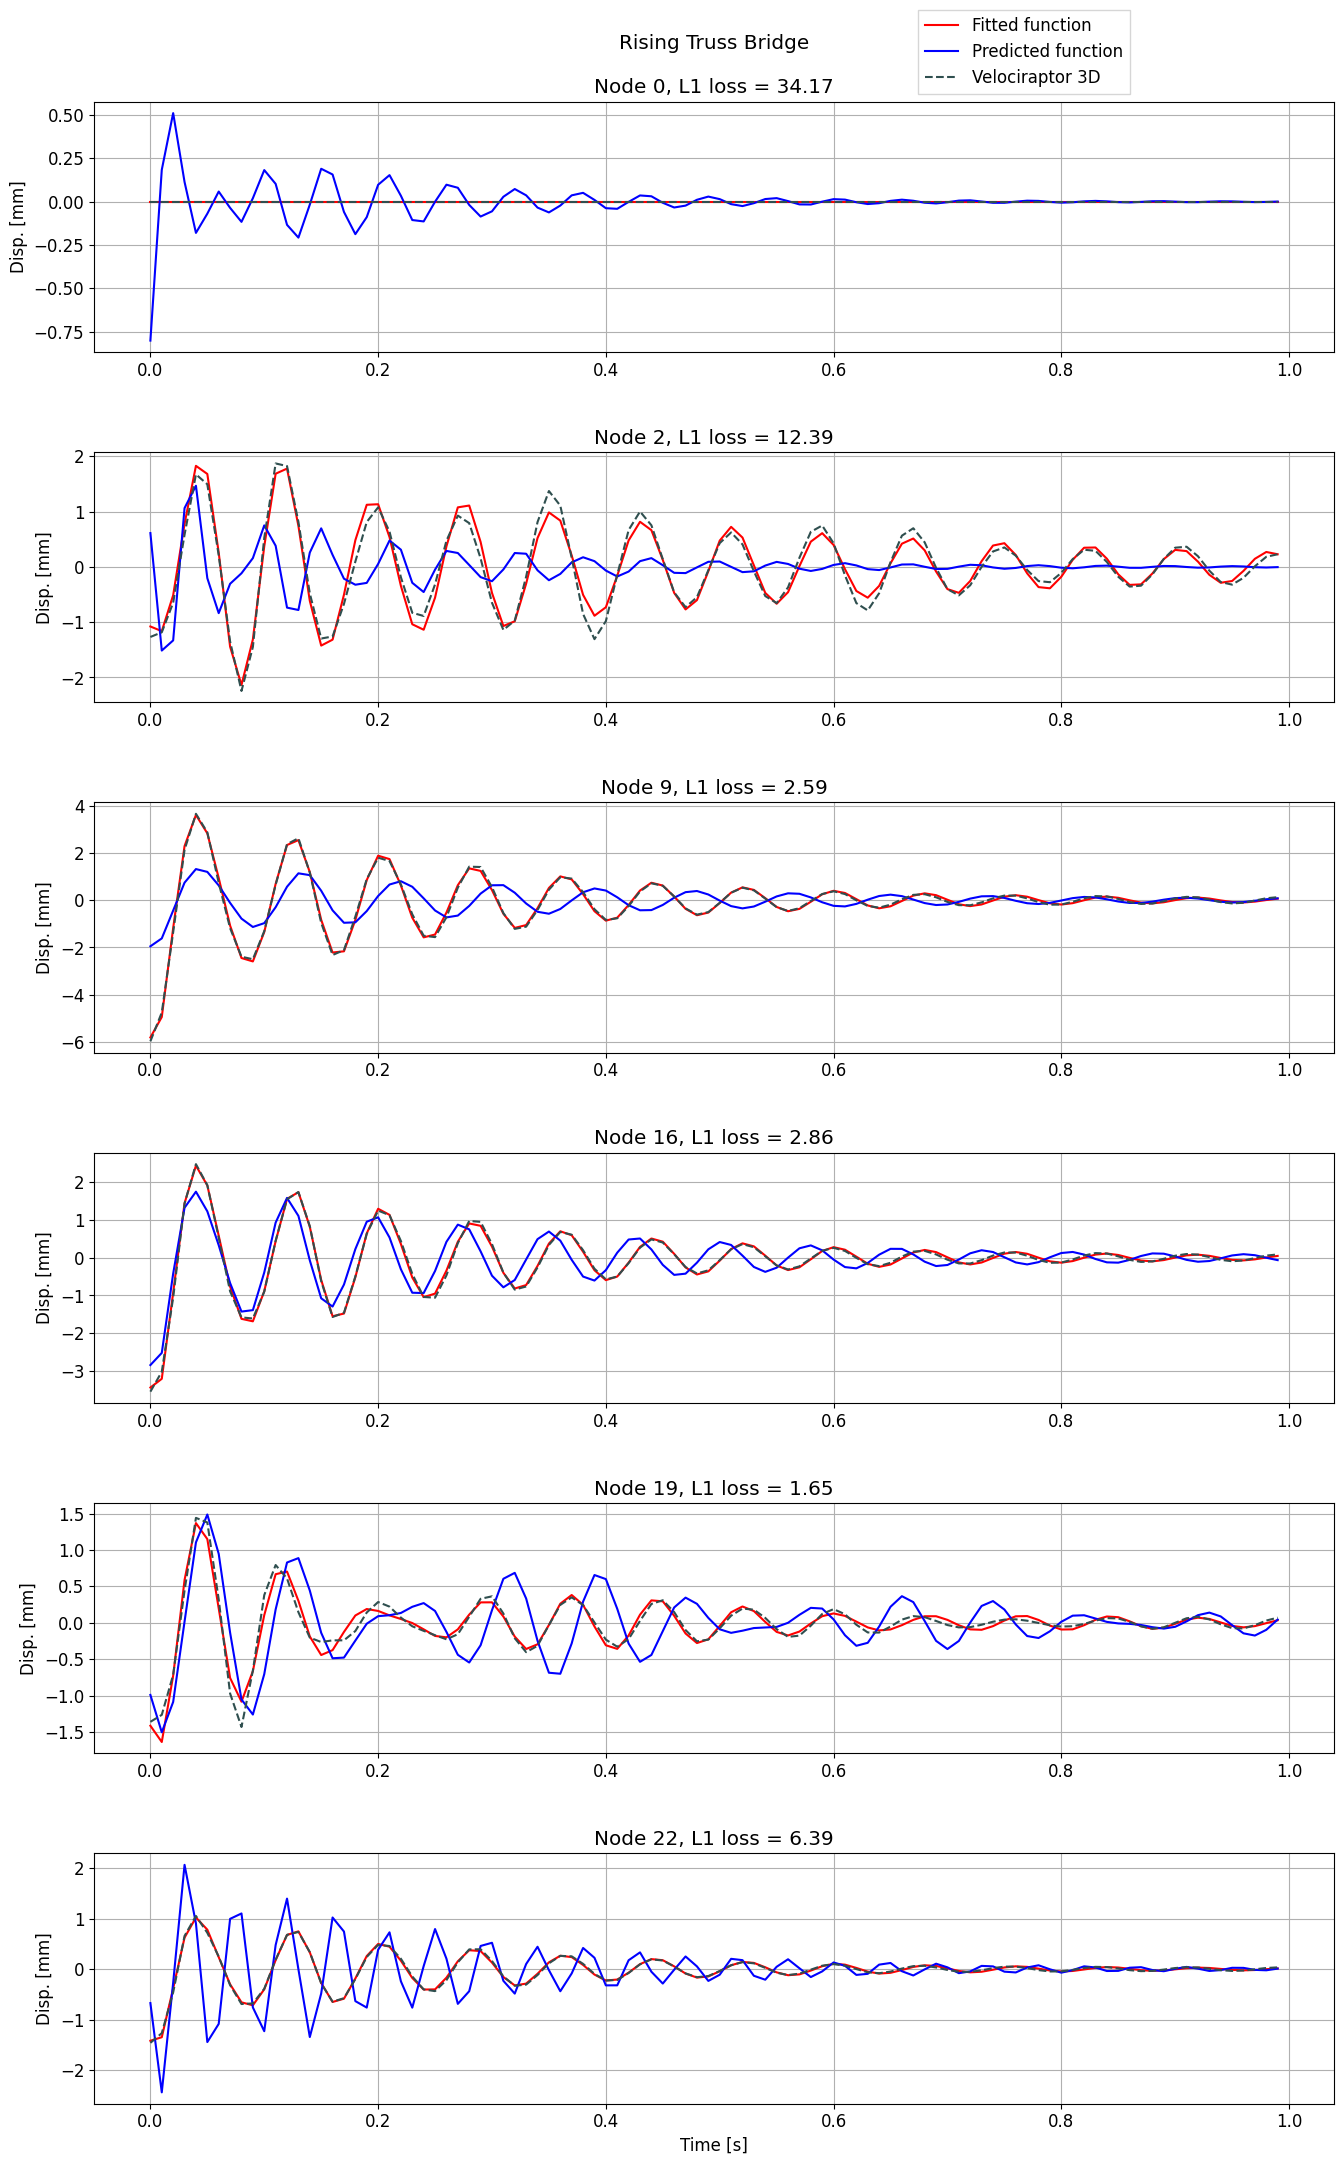

In [171]:
# rising truss

import matplotlib as mpl
mpl.get_configdir()


dt = 0.01
T = 1
time = np.arange(0,T,dt)
bridgenr = 0

nodes = [0,2,9,16,19,22]

fig, axes = plt.subplots(len(nodes),1)
j = 0

fig.set_figheight(26)
fig.set_figwidth(16)

plt.rcParams['font.size'] = '12'
for i in nodes:

    ##best

    loss = round(F.l1_loss(model_best(data_set_rising[bridgenr])[i], data_set_rising[bridgenr].y[i]).item(), 2)

    labels = data_set_rising[bridgenr].y[i].tolist()
    predicted_params = model_best(data_set_rising[bridgenr])[i].tolist()
    id = data_set_rising[bridgenr].bridge_id
    original = displacement_z_data_rising[id][i][:100]

    fitted = damped_sine_wave_2(time, *labels)

    id = data_set_rising[bridgenr].bridge_id
    prediction_fitted = damped_sine_wave_2(time, *predicted_params)

    if (j == 0):
        axes[j].set_title('Rising Truss Bridge'+'\n'+'\n'+'Node '+str(i)+", L1 loss = "+str(loss))
    else:
        axes[j].set_title('Node '+str(i)+", L1 loss = "+str(loss))


    axes[j].plot(time, fitted, 'r-', label='Fitted function')
    axes[j].plot(time, prediction_fitted, 'b-', label='Predicted function')
    axes[j].plot(time, original, color='darkslategrey', linestyle='--', label='Velociraptor 3D')
    #axes[j,0].set_title('Trained with MSE, Node '+str(i))

    axes[j].set_ylabel('Disp. [mm]')
    axes[j].grid()
    #axes[j,0].legend(loc="lower right")   
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.75, 1.4),
          fancybox=False, shadow=False, ncol=1)  

    if (j == len(nodes)-1):
        axes[j].set_xlabel('Time [s]')

    print('node '+str(i)+' best')
    print(labels)
    print(predicted_params)
    

    j+=1

# Show the figure with subplots
plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.4)
plt.show()
